In [1]:
!pip install av
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00


In [2]:
# Cell 1: 导入库和环境设置

# 抑制CUDA和TensorFlow警告信息
import os
import warnings

# 设置环境变量 - 必须在导入TensorFlow之前设置
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 抑制所有TensorFlow日志 (0=全部, 1=INFO, 2=WARNING, 3=ERROR)
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'  # 异步CUDA执行
os.environ['PYTHONWARNINGS'] = 'ignore'   # 抑制Python警告

# 抑制CUDA相关警告
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # 禁用oneDNN优化警告
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # GPU内存动态增长
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'  # 明确指定可见的GPU设备

# 抑制cuDNN/cuFFT/cuBLAS重复注册警告
os.environ['TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS'] = '1'

# 抑制所有警告
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# 修复CUDA多进程问题
import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass  # 如果已经设置过，忽略错误

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
import gc
import json
import time
import sys
from pathlib import Path
from datetime import datetime
from PIL import Image
warnings.filterwarnings('ignore')

# PyTorch相关
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from torchvision.io import read_video
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# 初始化CUDA并抑制警告
if torch.cuda.is_available():
    # 初始化CUDA上下文以避免后续警告
    torch.cuda.init()
    # 设置CUDA设备
    torch.cuda.set_device(0)
    # 清理CUDA缓存
    torch.cuda.empty_cache()
    print(f"🚀 CUDA已初始化，检测到 {torch.cuda.device_count()} 个GPU设备")
    for i in range(torch.cuda.device_count()):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3
        print(f"   - GPU {i}: {gpu_name} ({gpu_memory:.1f} GB)")
else:
    print("⚠️ CUDA不可用，将使用CPU模式")

# 机器学习指标
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, balanced_accuracy_score
)
from sklearn.model_selection import train_test_split

# 系统监控和性能分析
import psutil
import traceback

# 高精度人脸检测 - MTCNN
try:
    # 在导入MTCNN之前进一步抑制TensorFlow警告
    import logging
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    
    # 抑制absl日志
    try:
        import absl.logging
        absl.logging.set_verbosity(absl.logging.ERROR)
    except ImportError:
        pass
    
    from mtcnn import MTCNN
    MTCNN_AVAILABLE = True
    print("✅ MTCNN已安装，支持高精度人脸检测")
    print("   - 人脸检测精度: 高")
    print("   - 检测置信度阈值: 0.9")
    print("   - API版本: 新版本 (v1.0.0+)")
    print("   - TensorFlow警告已抑制")
except ImportError:
    MTCNN_AVAILABLE = False
    print("⚠️ MTCNN未安装，将使用OpenCV人脸检测")
    print("   - 人脸检测精度: 中等")
    print("   - 建议安装MTCNN以获得更高精度:")
    print("   - 安装命令: !pip install mtcnn")
    print("   - 或者: !pip install mtcnn[tensorflow]")
    print("   - 注意: 需要TensorFlow >= 2.12")
    print("   - 影响: 人脸检测精度略有降低，但不影响整体训练")

# 视频处理 (PyAV)
try:
    import av
    PYAV_AVAILABLE = True
    print("✅ PyAV已安装，支持GPU视频处理")
except ImportError:
    PYAV_AVAILABLE = False
    print("⚠️ PyAV未安装，视频处理将回退到CPU模式")

# 数据增强
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True
except ImportError:
    ALBUMENTATIONS_AVAILABLE = False
    print("警告: albumentations未安装，将使用基础数据增强")

# 频域分析支持
try:
    from scipy import fftpack
    from scipy.signal import butter, filtfilt
    SCIPY_AVAILABLE = True
    print("✅ SciPy已安装，支持频域分析")
except ImportError:
    SCIPY_AVAILABLE = False
    print("⚠️ SciPy未安装，频域分析功能受限")

print("✅ 所有库导入完成")

🚀 CUDA已初始化，检测到 2 个GPU设备
   - GPU 0: Tesla T4 (14.7 GB)
   - GPU 1: Tesla T4 (14.7 GB)


E0000 00:00:1753857440.974377      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753857441.075136      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ MTCNN已安装，支持高精度人脸检测
   - 人脸检测精度: 高
   - 检测置信度阈值: 0.9
   - API版本: 新版本 (v1.0.0+)
   - TensorFlow警告已抑制
✅ PyAV已安装，支持GPU视频处理
✅ SciPy已安装，支持频域分析
✅ 所有库导入完成


In [3]:
# Cell 2: 全局配置和工具函数 - Kaggle T4 优化版本

def set_seed(seed=42):
    """设置随机种子确保可重复性"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Kaggle环境优化：平衡性能和可重复性
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

# Kaggle T4 GPU配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    
    print(f"🎮 GPU数量: {gpu_count}")
    print(f"🎮 GPU型号: {gpu_name}")
    print(f"💾 单GPU内存: {gpu_memory:.1f} GB")
    print(f"💾 总GPU内存: {gpu_memory * gpu_count:.1f} GB")
    
    # 多GPU配置
    USE_MULTI_GPU = gpu_count > 1
    if USE_MULTI_GPU:
        print(f"✅ 检测到 {gpu_count} 个GPU，启用多GPU并行训练")
        # 双T4 GPU优化配置
        torch.cuda.set_per_process_memory_fraction(0.8)  # 双T4可以使用更多内存
    else:
        print("📝 单GPU模式")
        torch.cuda.set_per_process_memory_fraction(0.7)  # 单GPU保守配置
    
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    print("✅ Kaggle T4 GPU优化配置已启用")
else:
    USE_MULTI_GPU = False

# 创建必要的目录
for dir_name in ['./data', './models', './logs', './results']:
    os.makedirs(dir_name, exist_ok=True)

# Kaggle环境检测
IS_KAGGLE = os.path.exists('/kaggle')
BASE_DATA_DIR = '/kaggle/input/ff-c23/FaceForensics++_C23' if IS_KAGGLE else './dataset/FaceForensics++_C23'

# 统一数据类型配置 - 全部使用FP32提升兼容性
USE_FP32_ONLY = True  # 强制使用FP32，确保最佳兼容性
print(f"数据类型策略: FP32 (兼容性优先)")

print(f"环境: {'Kaggle' if IS_KAGGLE else '本地'}")
print(f"数据基础路径: {BASE_DATA_DIR}")
print("✅ 环境设置完成")

使用设备: cuda
🎮 GPU数量: 2
🎮 GPU型号: Tesla T4
💾 单GPU内存: 14.7 GB
💾 总GPU内存: 29.5 GB
✅ 检测到 2 个GPU，启用多GPU并行训练
✅ Kaggle T4 GPU优化配置已启用
数据类型策略: FP32 (兼容性优先)
环境: Kaggle
数据基础路径: /kaggle/input/ff-c23/FaceForensics++_C23
✅ 环境设置完成


In [4]:
# Cell 3: 数据处理函数
def extract_frames_gpu_accelerated(video_path, max_frames=16, target_size=(224, 224),
                                  quality_threshold=20, use_gpu=True, use_mtcnn=True):
    """GPU加速的帧提取函数 - 集成MTCNN人脸检测"""
    try:
        # 检查PyAV是否可用
        if not globals().get('PYAV_AVAILABLE', False):
            print(f"PyAV不可用，使用CPU回退处理: {video_path}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold, use_mtcnn)
            
        # 设备选择 - 优先使用GPU
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # 使用torchvision的GPU加速视频读取
        if not use_gpu:
            device = torch.device('cpu')
            
        # 读取视频（torchvision自动处理解码）
        try:
            video_tensor, audio, info = read_video(video_path, pts_unit='sec')
            # video_tensor shape: (T, H, W, C)
        except Exception as e:
            print(f"GPU视频读取失败，回退到CPU: {e}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold, use_mtcnn)
        
        if video_tensor.size(0) == 0:
            return []
            
        # 移动到GPU进行处理
        video_tensor = video_tensor.to(device, non_blocking=True)
        total_frames = video_tensor.size(0)
        
        # 智能帧采样策略
        if total_frames <= max_frames:
            frame_indices = torch.arange(0, total_frames, device=device)
        else:
            # 均匀采样
            step = total_frames / max_frames
            frame_indices = torch.arange(0, total_frames, step, device=device).long()[:max_frames]
        
        # 批量提取帧
        selected_frames = video_tensor[frame_indices]  # (max_frames, H, W, C)
        
        # GPU上进行质量检测（使用Sobel算子代替Laplacian）
        if quality_threshold > 0:
            # 转换为灰度图进行质量检测（先转换为float类型）
            gray_frames = selected_frames.float().mean(dim=-1, keepdim=True)  # (T, H, W, 1)
            gray_frames = gray_frames.permute(0, 3, 1, 2)  # (T, 1, H, W)
            
            # 使用Sobel算子计算图像质量
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            
            grad_x = F.conv2d(gray_frames, sobel_x, padding=1)
            grad_y = F.conv2d(gray_frames, sobel_y, padding=1)
            quality_scores = (grad_x.pow(2) + grad_y.pow(2)).mean(dim=[1, 2, 3])
            
            # 过滤低质量帧
            quality_mask = quality_scores > quality_threshold
            if quality_mask.sum() > 0:
                selected_frames = selected_frames[quality_mask]
            
        # GPU上进行尺寸调整
        selected_frames = selected_frames.permute(0, 3, 1, 2).float()  # (T, C, H, W)
        if selected_frames.size(-1) != target_size[0] or selected_frames.size(-2) != target_size[1]:
            selected_frames = F.interpolate(selected_frames, size=target_size, 
                                          mode='bilinear', align_corners=False)
        
        # 确保帧数足够
        current_frames = selected_frames.size(0)
        if current_frames < max_frames:
            # 重复最后一帧
            if current_frames > 0:
                last_frame = selected_frames[-1:].repeat(max_frames - current_frames, 1, 1, 1)
                selected_frames = torch.cat([selected_frames, last_frame], dim=0)
            else:
                # 创建黑色帧
                selected_frames = torch.zeros(max_frames, 3, target_size[0], target_size[1], 
                                            device=device, dtype=torch.float32)
        
        # 限制到最大帧数
        selected_frames = selected_frames[:max_frames]
        
        # 转换回CPU numpy格式（为了兼容现有代码）
        frames_cpu = selected_frames.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
        frames_list = [frame for frame in frames_cpu]
        
        # 应用MTCNN人脸检测和裁剪
        if use_mtcnn and globals().get('MTCNN_AVAILABLE', False):
            frames_list = apply_mtcnn_face_detection(frames_list, target_size)
        
        return frames_list
        
    except Exception as e:
        print(f"GPU帧提取失败，回退到CPU: {e}")
        return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold, use_mtcnn)

def apply_mtcnn_face_detection(frames, target_size=(224, 224)):
    """使用MTCNN进行人脸检测和裁剪 - 兼容新版本API"""
    try:
        # 新版本MTCNN构造函数不需要参数
        detector = MTCNN()
        processed_frames = []
        
        for frame in frames:
            # MTCNN需要RGB格式
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if len(frame.shape) == 3 else frame
            
            # 检测人脸 - 新版本API在detect_faces方法中传递参数
            results = detector.detect_faces(
                frame_rgb,
                min_face_size=40,  # 最小人脸尺寸
                threshold_pnet=0.6,  # PNet阈值
                threshold_rnet=0.7,  # RNet阈值  
                threshold_onet=0.8   # ONet阈值
            )
            
            if results and len(results) > 0:
                # 选择置信度最高的人脸
                best_face = max(results, key=lambda x: x['confidence'])
                
                if best_face['confidence'] > 0.9:  # 高置信度阈值
                    # 提取人脸区域
                    x, y, w, h = best_face['box']
                    
                    # 扩展边界框以包含更多上下文
                    margin = 0.2
                    x_margin = int(w * margin)
                    y_margin = int(h * margin)
                    
                    x1 = max(0, x - x_margin)
                    y1 = max(0, y - y_margin)
                    x2 = min(frame_rgb.shape[1], x + w + x_margin)
                    y2 = min(frame_rgb.shape[0], y + h + y_margin)
                    
                    # 裁剪人脸
                    face_crop = frame_rgb[y1:y2, x1:x2]
                    
                    # 使用统一的帧处理函数
                    processed_frame = resize_and_validate_frame(face_crop, target_size, 0)  # MTCNN不需要额外质量检查
                    if processed_frame is None:
                        processed_frames.append(cv2.resize(face_crop, target_size))  # 如果处理失败，返回原帧
                    else:
                        processed_frames.append(processed_frame)
                else:
                    # 置信度不够，使用原始帧
                    processed_frames.append(cv2.resize(frame_rgb, target_size))
            else:
                # 没有检测到人脸，使用原始帧
                processed_frames.append(cv2.resize(frame_rgb, target_size))
        
        return processed_frames
        
    except Exception as e:
        print(f"MTCNN人脸检测失败，使用原始帧: {e}")
        return [cv2.resize(frame, target_size) for frame in frames]

def resize_and_validate_frame(frame, target_size, quality_threshold=20):
    """统一的帧处理函数：调整大小并验证质量"""
    if frame is None:
        return None
    
    # 调整尺寸
    resized_frame = cv2.resize(frame, target_size)
    
    # 质量检查
    if quality_threshold > 0:
        # 计算图像的方差作为质量指标
        gray = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY) if len(resized_frame.shape) == 3 else resized_frame
        variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        if variance < quality_threshold:
            return None
    
    return resized_frame

def extract_frames_cpu_fallback(video_path, max_frames=16, target_size=(224, 224), quality_threshold=20, use_mtcnn=True):
    """CPU回退的帧提取函数 - 集成MTCNN"""
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        print(f"无法打开视频: {video_path}")
        return frames

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return frames

    # 均匀采样策略
    if total_frames <= max_frames:
        frame_indices = list(range(0, total_frames, max(1, total_frames // max_frames)))
    else:
        step = max(1, total_frames // max_frames)
        frame_indices = list(range(0, total_frames, step))[:max_frames]

    frame_count = 0
    for frame_idx in frame_indices:
        if frame_count >= max_frames:
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # 使用统一的帧处理函数
            processed_frame = resize_and_validate_frame(frame, target_size, quality_threshold)
            if processed_frame is None:
                continue
            frame = processed_frame
            frames.append(frame)
            frame_count += 1

    cap.release()

    # 如果帧数不足，重复最后一帧
    while len(frames) < max_frames and len(frames) > 0:
        frames.append(frames[-1].copy())

    # 应用MTCNN人脸检测
    if use_mtcnn and globals().get('MTCNN_AVAILABLE', False):
        frames = apply_mtcnn_face_detection(frames, target_size)

    return frames[:max_frames]

# 为了向后兼容，保留原函数名，但移除冗余参数
def extract_frames_memory_efficient(video_path, max_frames=16, target_size=(224, 224),
                                   quality_threshold=20, use_mtcnn=True):
    """兼容性包装函数，优先使用GPU加速，集成MTCNN
    注意：skip_frames参数已移除，因为GPU版本使用更智能的采样策略
    """
    return extract_frames_gpu_accelerated(video_path, max_frames, target_size, quality_threshold, use_mtcnn=use_mtcnn)

def process_videos_simple(base_data_dir, max_videos_per_class=60, max_frames=16, max_real=None, max_fake=None):
    """简化的视频处理函数 - 优化假视频平均分配"""
    # 打印设备信息（只打印一次）
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 数据处理使用设备: {device}")
    
    # 向后兼容：如果指定了新参数，使用新参数；否则使用旧参数
    if max_real is None:
        max_real = max_videos_per_class
    if max_fake is None:
        max_fake = max_videos_per_class
    
    data_list = []
    fake_methods = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'DeepFakeDetection']

    print("开始处理真实视频...")
    # 处理真实视频
    original_dir = os.path.join(base_data_dir, 'original')
    if os.path.exists(original_dir):
        video_files = [f for f in os.listdir(original_dir)
                      if f.endswith(('.mp4', '.avi', '.mov'))]
        
        if len(video_files) > max_real:
            video_files = random.sample(video_files, max_real)

        print(f"找到 {len(video_files)} 个真实视频")

        for video_file in tqdm(video_files, desc="处理真实视频"):
            try:
                video_path = os.path.join(original_dir, video_file)
                frames = extract_frames_memory_efficient(video_path, max_frames)
                
                if len(frames) >= max_frames // 2:  # 至少要有一半的帧
                    data_list.append({
                        'video_path': video_path,
                        'frames': frames,
                        'label': 0,  # 真实视频
                        'method': 'original'
                    })
            except Exception as e:
                print(f"处理视频 {video_file} 时出错: {e}")
                continue

    # 处理伪造视频 - 平均分配策略
    print("开始处理伪造视频...")
    
    # 统计每种方法的可用视频数量
    method_videos = {}
    total_available_fake = 0
    
    for method in fake_methods:
        method_dir = os.path.join(base_data_dir, method)
        if os.path.exists(method_dir):
            videos = [os.path.join(method_dir, f) for f in os.listdir(method_dir) 
                     if f.endswith(('.mp4', '.avi', '.mov'))]
            method_videos[method] = videos
            total_available_fake += len(videos)
            print(f"  {method}: {len(videos)} 个视频")
        else:
            method_videos[method] = []
            print(f"  {method}: 目录不存在")
    
    print(f"总共可用假视频: {total_available_fake} 个")
    
    # 计算每种方法应该采样的视频数量（平均分配）
    available_methods = [method for method in fake_methods if len(method_videos[method]) > 0]
    if not available_methods:
        print("❌ 未找到任何假视频方法")
        return data_list
    
    videos_per_method = max_fake // len(available_methods)
    remaining_videos = max_fake % len(available_methods)
    
    print(f"平均分配策略: 每种方法 {videos_per_method} 个视频")
    if remaining_videos > 0:
        print(f"剩余 {remaining_videos} 个视频将分配给前 {remaining_videos} 种方法")
    
    # 为每种方法采样视频
    selected_fake_videos = []
    for i, method in enumerate(available_methods):
        # 计算当前方法应该采样的数量
        current_method_quota = videos_per_method
        if i < remaining_videos:  # 前几种方法多分配一个
            current_method_quota += 1
        
        available_videos = method_videos[method]
        
        # 如果可用视频数量少于配额，全部使用
        if len(available_videos) <= current_method_quota:
            method_selected = available_videos
            print(f"  {method}: 使用全部 {len(method_selected)} 个视频")
        else:
            # 随机采样指定数量
            method_selected = random.sample(available_videos, current_method_quota)
            print(f"  {method}: 采样 {len(method_selected)} 个视频")
        
        selected_fake_videos.extend([(v, method) for v in method_selected])
    
    print(f"总共选择 {len(selected_fake_videos)} 个假视频进行处理")
    
    # 打乱选择的假视频顺序
    random.shuffle(selected_fake_videos)
    
    # 处理选择的假视频
    for video_path, method in tqdm(selected_fake_videos, desc="处理伪造视频"):
        try:
            frames = extract_frames_memory_efficient(video_path, max_frames)
            
            if len(frames) >= max_frames // 2:
                data_list.append({
                    'video_path': video_path,
                    'frames': frames,
                    'label': 1,  # 伪造视频
                    'method': method
                })
        except Exception as e:
            print(f"处理视频 {os.path.basename(video_path)} 时出错: {e}")
            continue

    # 统计最终结果
    method_counts = {}
    for item in data_list:
        if item['label'] == 1:  # 只统计假视频
            method = item['method']
            method_counts[method] = method_counts.get(method, 0) + 1
    
    print(f"\n✅ 数据处理完成，共处理 {len(data_list)} 个视频")
    print("假视频方法分布:")
    for method, count in method_counts.items():
        print(f"  {method}: {count} 个视频")
    
    return data_list

def create_dataset_split(data_list, test_size=0.2, val_size=0.1):
    """创建数据集划分"""
    # 分离真实和伪造数据
    real_data = [item for item in data_list if item['label'] == 0]
    fake_data = [item for item in data_list if item['label'] == 1]
    
    print(f"真实视频: {len(real_data)} 个")
    print(f"伪造视频: {len(fake_data)} 个")
    
    # 分别划分真实和伪造数据
    real_train, real_temp = train_test_split(real_data, test_size=test_size+val_size, random_state=42)
    real_val, real_test = train_test_split(real_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    fake_train, fake_temp = train_test_split(fake_data, test_size=test_size+val_size, random_state=42)
    fake_val, fake_test = train_test_split(fake_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    # 合并数据
    train_data = real_train + fake_train
    val_data = real_val + fake_val
    test_data = real_test + fake_test
    
    # 打乱数据
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)
    
    return train_data, val_data, test_data

def save_dataset_to_csv(data_list, filename):
    """将数据集保存为CSV文件 - 支持预提取帧路径"""
    df_data = []
    for item in data_list:
        # 检查是否为预提取的帧数据
        if 'frame_path' in item:
            df_data.append({
                'frame_path': item['frame_path'],
                'label': item['label'],
                'method': item['method'],
                'num_frames': item.get('num_frames', 16)
            })
        else:
            # 向后兼容：原始视频路径格式
            df_data.append({
                'video_path': item['video_path'],
                'label': item['label'],
                'method': item['method'],
                'num_frames': len(item['frames'])
            })
    
    df = pd.DataFrame(df_data)
    df.to_csv(filename, index=False)
    print(f"数据集已保存到: {filename}")
    return df

print("✅ 数据处理函数定义完成")

✅ 数据处理函数定义完成


In [5]:
# Cell 4: 数据集类定义

# 必要的导入
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

class DeepfakeVideoDataset(Dataset):
    """深度伪造视频数据集类 - 支持预提取帧和多模态特征"""
    
    def __init__(self, csv_file, max_frames=16, gpu_preprocessing=True, 
                 extract_fourier=True, extract_compression=True, transform=None):
        """
        初始化数据集 - 专用于预提取帧的GPU预处理
        
        Args:
            csv_file: CSV文件路径（必须包含frame_path列）
            max_frames: 最大帧数
            gpu_preprocessing: 是否启用GPU预处理
            extract_fourier: 是否提取傅里叶特征
            extract_compression: 是否提取压缩特征
            transform: 数据变换（可选）
        """
        self.csv_file = csv_file
        self.max_frames = max_frames
        self.gpu_preprocessing = gpu_preprocessing
        self.extract_fourier = extract_fourier
        self.extract_compression = extract_compression
        self.transform = transform  # 添加transform属性
        
        # 加载数据
        self.df = pd.read_csv(csv_file)
        
        # 验证必须包含frame_path列
        if 'frame_path' not in self.df.columns:
            raise ValueError(f"CSV文件 {csv_file} 必须包含 'frame_path' 列。请先运行预提取流程。")
        
        print(f"✅ 预提取帧模式，共 {len(self.df)} 个样本")
        
        # GPU设备
        self.device = torch.device('cuda' if torch.cuda.is_available() and gpu_preprocessing else 'cpu')
        
        # 预计算的标准化参数（ImageNet标准）
        self.mean_tensor = torch.tensor([0.485, 0.456, 0.406], device=self.device).view(1, 3, 1, 1)
        self.std_tensor = torch.tensor([0.229, 0.224, 0.225], device=self.device).view(1, 3, 1, 1)
        
        # 预计算数据统计信息
        self._compute_dataset_stats()
        
        print(f"✅ 数据集初始化完成: {len(self)} 个样本")
        print(f"🚀 GPU预处理: {self.gpu_preprocessing} (设备: {self.device})")
        if self.extract_fourier:
            print("📊 启用频域特征提取")
        if self.extract_compression:
            print("🔍 启用压缩伪影分析")

    def _compute_dataset_stats(self):
        """预计算数据集统计信息"""
        try:
            self.real_count = len(self.df[self.df['label'] == 0])
            self.fake_count = len(self.df[self.df['label'] == 1])
        except Exception as e:
            print(f"⚠️ 计算数据统计时出错: {e}")
            self.real_count = 0
            self.fake_count = 0
        
        print(f"📊 数据分布: 真实={self.real_count}, 伪造={self.fake_count}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """获取数据项 - 专用于预提取帧的GPU预处理"""
        try:
            row = self.df.iloc[idx]
            label = row['label']
            frame_path = row['frame_path']

            # 从预提取的帧文件加载
            video_tensor = self._load_preextracted_frames(frame_path)
            
            # 确保帧数一致
            video_tensor = self._ensure_frame_count(video_tensor)
            
            # GPU预处理
            if self.gpu_preprocessing and video_tensor.device != self.device:
                video_tensor = video_tensor.to(self.device, non_blocking=True)
            
            # 标准化
            video_tensor = self._normalize_frames(video_tensor)
            
            # 应用变换（如果有）
            if self.transform:
                video_tensor = self._apply_transforms(video_tensor)

            # 提取多模态特征
            additional_features = self._extract_additional_features(video_tensor)

            label_tensor = torch.tensor(label, dtype=torch.float32)
            
            # 清理GPU内存
            if self.gpu_preprocessing:
                torch.cuda.empty_cache()
            
            # 返回数据和额外特征
            if additional_features:
                return video_tensor, label_tensor, additional_features
            else:
                return video_tensor, label_tensor
            
        except Exception as e:
            print(f"⚠️ 获取数据项 {idx} 时出错: {e}")
            # 返回默认数据
            return self._get_default_item()

    def _extract_additional_features(self, frames_tensor):
        """提取额外的多模态特征"""
        features = {}
        
        try:
            # 将tensor转换为numpy进行特征提取
            if frames_tensor.device != torch.device('cpu'):
                frames_np = frames_tensor.cpu().numpy()
            else:
                frames_np = frames_tensor.numpy()
            
            # 反标准化以获得原始像素值
            mean_np = self.mean_tensor.cpu().numpy().reshape(1, 3, 1, 1)
            std_np = self.std_tensor.cpu().numpy().reshape(1, 3, 1, 1)
            frames_np = frames_np * std_np + mean_np
            frames_np = np.clip(frames_np * 255.0, 0, 255).astype(np.uint8)
            
            if self.extract_fourier:
                # 提取频域特征（使用中间帧）
                mid_frame_idx = len(frames_np) // 2
                mid_frame = frames_np[mid_frame_idx].transpose(1, 2, 0)  # CHW -> HWC
                
                try:
                    # 检查函数是否存在
                    if 'extract_fourier_features' in globals():
                        fourier_features = extract_fourier_features(mid_frame)
                        if fourier_features:
                            features['fourier'] = fourier_features
                    else:
                        # 如果函数不存在，创建简单的频域特征替代
                        gray_frame = np.mean(mid_frame, axis=2)
                        fft = np.fft.fft2(gray_frame)
                        fft_magnitude = np.abs(fft)
                        features['fourier'] = {
                            'mean_magnitude': float(np.mean(fft_magnitude)),
                            'std_magnitude': float(np.std(fft_magnitude)),
                            'max_magnitude': float(np.max(fft_magnitude))
                        }
                except Exception as e:
                    print(f"⚠️ 频域特征提取失败: {e}")
            
            if self.extract_compression:
                # 提取压缩伪影特征
                compression_features = []
                for i in range(0, len(frames_np), 4):  # 每4帧采样一次
                    frame = frames_np[i].transpose(1, 2, 0)  # CHW -> HWC
                    try:
                        # 检查函数是否存在
                        if 'analyze_compression_artifacts' in globals():
                            comp_feat = analyze_compression_artifacts(frame)
                            if comp_feat:
                                compression_features.append(comp_feat)
                        else:
                            # 如果函数不存在，创建简单的压缩特征替代
                            gray_frame = np.mean(frame, axis=2)
                            # 简单的DCT能量计算
                            dct_energy = float(np.var(gray_frame))
                            # 简单的边缘密度计算
                            edges = np.abs(np.gradient(gray_frame.astype(float)))
                            edge_density = float(np.mean(edges[0]**2 + edges[1]**2))
                            
                            comp_feat = {
                                'dct_energy': dct_energy,
                                'edge_density': edge_density,
                                'dct_mean': dct_energy,
                                'high_freq_energy': dct_energy * 0.1
                            }
                            compression_features.append(comp_feat)
                    except Exception as e:
                        print(f"⚠️ 压缩特征提取失败: {e}")
                        continue
                
                if compression_features:
                    # 聚合压缩特征
                    features['compression'] = {
                        'dct_mean': np.mean([f.get('dct_mean', f.get('dct_energy', 0)) for f in compression_features]),
                        'dct_std': np.std([f.get('dct_mean', f.get('dct_energy', 0)) for f in compression_features]),
                        'dct_energy': np.mean([f.get('dct_energy', 0) for f in compression_features]),
                        'high_freq_energy': np.mean([f.get('high_freq_energy', f.get('dct_energy', 0) * 0.1) for f in compression_features]),
                        'edge_density': np.mean([f.get('edge_density', 0) for f in compression_features])
                    }
            
            # 计算时序一致性特征
            if len(frames_np) > 1:
                temporal_features = self._compute_temporal_consistency_tensor(frames_np)
                if temporal_features:
                    features['temporal'] = temporal_features
            
            return features if features else None
            
        except Exception as e:
            print(f"⚠️ 提取额外特征失败: {e}")
            return None

    def _compute_temporal_consistency(self, frames):
        """计算时序一致性特征（向后兼容）"""
        try:
            # 计算相邻帧之间的差异
            frame_diffs = []
            for i in range(len(frames) - 1):
                diff = np.mean(np.abs(frames[i+1].astype(float) - frames[i].astype(float)))
                frame_diffs.append(diff)
            
            if frame_diffs:
                return {
                    'mean_frame_diff': np.mean(frame_diffs),
                    'std_frame_diff': np.std(frame_diffs),
                    'max_frame_diff': np.max(frame_diffs),
                    'temporal_smoothness': 1.0 / (1.0 + np.std(frame_diffs))
                }
            
            return None
            
        except Exception as e:
            print(f"⚠️ 计算时序特征失败: {e}")
            return None
    
    def _compute_temporal_consistency_tensor(self, frames_np):
        """计算时序一致性特征（tensor版本）"""
        try:
            # 计算相邻帧之间的差异
            frame_diffs = []
            for i in range(len(frames_np) - 1):
                diff = np.mean(np.abs(frames_np[i+1].astype(float) - frames_np[i].astype(float)))
                frame_diffs.append(diff)
            
            if frame_diffs:
                return {
                    'mean_frame_diff': np.mean(frame_diffs),
                    'std_frame_diff': np.std(frame_diffs),
                    'max_frame_diff': np.max(frame_diffs),
                    'temporal_smoothness': 1.0 / (1.0 + np.std(frame_diffs))
                }
            
            return None
            
        except Exception as e:
            print(f"⚠️ 计算时序特征失败: {e}")
            return None

    def _load_preextracted_frames(self, frame_path):
        """从预提取的帧文件加载数据"""
        try:
            # 直接加载tensor（数据准备阶段保存的格式）
            frames_tensor = torch.load(frame_path, map_location='cpu')
            
            # 如果加载的是字典格式，提取frames
            if isinstance(frames_tensor, dict):
                frames_tensor = frames_tensor['frames']
            
            # 确保数据类型和范围正确
            if frames_tensor.dtype != torch.float32:
                frames_tensor = frames_tensor.float()
            
            # 数据准备阶段已经将像素值标准化到[0,1]，这里需要恢复到[0,255]
            if frames_tensor.max() <= 1.0:
                frames_tensor = frames_tensor * 255.0
            
            return frames_tensor
            
        except Exception as e:
            print(f"加载预提取帧失败 {frame_path}: {e}")
            return self._create_default_frames_tensor()
    

    
    def _create_default_frames_tensor(self):
        """创建默认帧张量"""
        # 创建随机噪声帧而不是全零帧，使训练更有意义
        frames_tensor = torch.randint(0, 50, (self.max_frames, 3, 224, 224), dtype=torch.float32)
        return frames_tensor
    
    def _ensure_frame_count(self, frames_tensor):
        """确保帧数一致"""
        current_frames = frames_tensor.shape[0]
        
        if current_frames < self.max_frames:
            # 重复最后一帧
            last_frame = frames_tensor[-1:]
            repeat_count = self.max_frames - current_frames
            repeated_frames = last_frame.repeat(repeat_count, 1, 1, 1)
            frames_tensor = torch.cat([frames_tensor, repeated_frames], dim=0)
        elif current_frames > self.max_frames:
            # 截取前max_frames帧
            frames_tensor = frames_tensor[:self.max_frames]
        
        return frames_tensor
    
    def _normalize_frames(self, frames_tensor):
        """标准化帧数据"""
        # 确保像素值在[0, 1]范围内
        if frames_tensor.max() > 1.0:
            frames_tensor = frames_tensor / 255.0
        
        # 移动标准化参数到正确设备
        if self.mean_tensor.device != frames_tensor.device:
            self.mean_tensor = self.mean_tensor.to(frames_tensor.device)
            self.std_tensor = self.std_tensor.to(frames_tensor.device)
        
        # ImageNet标准化
        frames_tensor = (frames_tensor - self.mean_tensor) / self.std_tensor
        
        # 限制数值范围防止梯度爆炸
        frames_tensor = torch.clamp(frames_tensor, -10, 10)
        
        return frames_tensor
    
    def _apply_transforms(self, frames_tensor):
        """应用数据变换"""
        try:
            # 将tensor转换回PIL格式进行变换
            transformed_frames = []
            
            # 反标准化以获得原始像素值
            denorm_tensor = frames_tensor * self.std_tensor + self.mean_tensor
            denorm_tensor = torch.clamp(denorm_tensor * 255.0, 0, 255)
            
            for i in range(frames_tensor.shape[0]):
                frame = denorm_tensor[i].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                frame_pil = Image.fromarray(frame)
                transformed_frame = self.transform(frame_pil)
                
                # 检查变换后是否有NaN或无穷值
                if torch.isnan(transformed_frame).any() or torch.isinf(transformed_frame).any():
                    print(f"⚠️ 检测到NaN/Inf值，跳过变换")
                    return frames_tensor
                
                transformed_frames.append(transformed_frame)
            
            return torch.stack(transformed_frames)
            
        except Exception as e:
            print(f"⚠️ 数据变换失败，使用原始数据: {e}")
            return frames_tensor
    


    def _get_default_item(self):
        """获取默认数据项（用于错误恢复）"""
        frames = self._create_default_frames()
        video_tensor = torch.stack([
            torch.from_numpy(frame).permute(2, 0, 1) for frame in frames
        ]).float() / 255.0
        
        # 标准化
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        video_tensor = (video_tensor - mean) / std
        
        label_tensor = torch.tensor(0.0, dtype=torch.float32)
        return video_tensor, label_tensor

    def _create_default_frames(self):
        """创建默认帧数据（numpy格式）"""
        # 创建随机噪声帧而不是全零帧，使训练更有意义
        frames = []
        for _ in range(self.max_frames):
            # 创建224x224x3的随机帧，值在[0, 50]范围内（低噪声）
            frame = np.random.randint(0, 50, (224, 224, 3), dtype=np.uint8)
            frames.append(frame)
        return frames



    def enable_ensemble_mode(self):
        """启用集成模式，提取所有可用特征"""
        self.extract_fourier = True
        self.extract_compression = True
        print("🎯 启用集成模式：所有特征提取已激活")

print("✅ 数据集类定义完成")

✅ 数据集类定义完成


In [6]:
# Cell 5: 模型定义
class OptimizedDeepfakeDetector(nn.Module):
    """优化的深度伪造检测器 - 集成多模态特征和Ensemble策略"""
    
    def __init__(self, num_classes=1, dropout_rate=0.3, use_attention=True, 
                 use_multimodal=False, ensemble_mode=False):
        super(OptimizedDeepfakeDetector, self).__init__()
        
        self.use_attention = use_attention
        self.use_multimodal = use_multimodal
        self.ensemble_mode = ensemble_mode
        
        # 主干网络 - ResNet50
        self.backbone = models.resnet50(pretrained=True)
        backbone_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # 移除最后的分类层
        
        # 时序特征提取
        self.temporal_conv = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1, 7, 7))
        )
        
        # 注意力机制
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=backbone_features, 
                num_heads=8, 
                dropout=dropout_rate,
                batch_first=True
            )
            self.attention_norm = nn.LayerNorm(backbone_features)
        
        # 多模态特征融合
        if use_multimodal:
            # 频域特征处理 - 修正输入维度
            self.fourier_fc = nn.Sequential(
                nn.Linear(5, 256),  # 频域特征实际维度为5 (mean, std, max, energy, entropy)
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(256, 128)
            )
            
            # 压缩伪影特征处理 - 修正输入维度
            self.compression_fc = nn.Sequential(
                nn.Linear(32, 64),  # 压缩特征扩展为32维
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(64, 32)
            )
            
            # 时序一致性特征处理
            self.temporal_fc = nn.Sequential(
                nn.Linear(4, 64),  # 时序特征维度为4
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(64, 32)
            )
            
            # 特征融合层 - 动态计算输入维度
            # 基础特征: backbone_features (2048)
            # 频域特征: 128 (fourier_fc输出)
            # 压缩特征: 32 (compression_fc输出)  
            # 时序特征: 32 (temporal_fc输出)
            fusion_dim = backbone_features + 128 + 32 + 32  # 2048 + 128 + 32 + 32 = 2240
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_dim, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256)
            )
            final_features = 256
        else:
            final_features = backbone_features
        
        # 集成模式的多个分类头
        if ensemble_mode:
            # 主分类器
            self.main_classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(final_features, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
            
            # 辅助分类器1 - 专注于空间特征
            self.spatial_classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(final_features, 64),
                nn.ReLU(inplace=True),
                nn.Linear(64, num_classes)
            )
            
            # 辅助分类器2 - 专注于时序特征
            self.temporal_classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(final_features, 64),
                nn.ReLU(inplace=True),
                nn.Linear(64, num_classes)
            )
            
            # 集成权重（可学习）
            self.ensemble_weights = nn.Parameter(torch.ones(3) / 3)
            
        else:
            # 单一分类器
            self.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(final_features, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
            
            # 添加单一分类器用于处理基础特征（当多模态特征处理失败时）
            self.single_classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(backbone_features, 128),  # 直接处理backbone特征
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
        
        # 初始化权重
        self._initialize_weights()
        
        print(f"✅ 模型初始化完成")
        print(f"   - 注意力机制: {'启用' if use_attention else '禁用'}")
        print(f"   - 多模态融合: {'启用' if use_multimodal else '禁用'}")
        print(f"   - 集成模式: {'启用' if ensemble_mode else '禁用'}")

    def _initialize_weights(self):
        """初始化权重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x, additional_features=None):
        """
        前向传播
        Args:
            x: 视频张量 (B, T, C, H, W)
            additional_features: 额外特征字典
        """
        batch_size, num_frames, channels, height, width = x.shape
        
        # 提取每帧的空间特征
        x_reshaped = x.view(batch_size * num_frames, channels, height, width)
        spatial_features = self.backbone(x_reshaped)  # (B*T, features)
        spatial_features = spatial_features.view(batch_size, num_frames, -1)  # (B, T, features)
        
        # 时序特征聚合
        if self.use_attention:
            # 使用注意力机制聚合时序特征
            attended_features, attention_weights = self.attention(
                spatial_features, spatial_features, spatial_features
            )
            attended_features = self.attention_norm(attended_features + spatial_features)
            # 全局平均池化
            temporal_features = torch.mean(attended_features, dim=1)  # (B, features)
        else:
            # 简单平均池化
            temporal_features = torch.mean(spatial_features, dim=1)  # (B, features)
        
        # 多模态特征融合
        if self.use_multimodal and additional_features is not None:
            fusion_features = [temporal_features]
            
            # 处理频域特征
            if 'fourier' in additional_features:
                try:
                    fourier_feat = additional_features['fourier']
                    if isinstance(fourier_feat, dict):
                        # 安全地提取数值特征
                        fourier_values = []
                        for value in fourier_feat.values():
                            if isinstance(value, (int, float)):
                                fourier_values.append(float(value))
                            elif isinstance(value, torch.Tensor):
                                if value.numel() == 1:
                                    fourier_values.append(float(value.item()))
                                else:
                                    fourier_values.append(float(value.mean().item()))
                            elif isinstance(value, np.ndarray):
                                if value.size == 1:
                                    fourier_values.append(float(value.item()))
                                else:
                                    fourier_values.append(float(value.mean()))
                            else:
                                fourier_values.append(0.0)  # 默认值
                        
                        # 确保有足够的特征维度
                        if len(fourier_values) < 5:  # fourier_fc期望5维输入
                            fourier_values.extend([0.0] * (5 - len(fourier_values)))
                        elif len(fourier_values) > 5:
                            fourier_values = fourier_values[:5]
                        
                        fourier_tensor = torch.tensor([fourier_values] * batch_size, 
                                                    dtype=torch.float32, 
                                                    device=temporal_features.device)
                    else:
                        # 如果已经是张量，确保正确的形状
                        if isinstance(fourier_feat, torch.Tensor):
                            fourier_tensor = fourier_feat.to(temporal_features.device)
                            if fourier_tensor.dim() == 1:
                                fourier_tensor = fourier_tensor.unsqueeze(0).repeat(batch_size, 1)
                        else:
                            # 创建默认张量
                            fourier_tensor = torch.zeros(batch_size, 5, 
                                                        dtype=torch.float32, 
                                                        device=temporal_features.device)
                    
                    fourier_processed = self.fourier_fc(fourier_tensor)
                    fusion_features.append(fourier_processed)
                except Exception as e:
                    print(f"⚠️ 频域特征处理失败: {e}")
                    # 使用默认特征
                    fourier_tensor = torch.zeros(batch_size, 5, 
                                                dtype=torch.float32, 
                                                device=temporal_features.device)
                    fourier_processed = self.fourier_fc(fourier_tensor)
                    fusion_features.append(fourier_processed)
            
            # 处理压缩伪影特征
            if 'compression' in additional_features:
                try:
                    comp_feat = additional_features['compression']
                    if isinstance(comp_feat, dict):
                        # 安全地提取压缩特征 - 修正为5个特征
                        comp_values = []
                        for key in ['dct_mean', 'dct_std', 'dct_energy', 'high_freq_energy', 'edge_density']:
                            if key in comp_feat:
                                value = comp_feat[key]
                                if isinstance(value, (int, float)):
                                    comp_values.append(float(value))
                                elif isinstance(value, torch.Tensor):
                                    comp_values.append(float(value.item() if value.numel() == 1 else value.mean().item()))
                                elif isinstance(value, np.ndarray):
                                    comp_values.append(float(value.item() if value.size == 1 else value.mean()))
                                else:
                                    comp_values.append(0.0)
                            else:
                                comp_values.append(0.0)
                        
                        # 扩展到32维：重复基础特征并添加派生特征
                        extended_values = comp_values.copy()
                        # 添加派生特征
                        extended_values.extend([
                            comp_values[0] * comp_values[1],  # mean * std
                            comp_values[2] / (comp_values[3] + 1e-8),  # energy ratio
                            comp_values[4] * comp_values[0],  # edge * mean
                            np.sqrt(abs(comp_values[2])),  # sqrt energy
                            comp_values[1] / (comp_values[0] + 1e-8),  # std/mean ratio
                        ])
                        # 重复填充到32维
                        while len(extended_values) < 32:
                            extended_values.extend(comp_values[:min(5, 32 - len(extended_values))])
                        
                        comp_tensor = torch.tensor([extended_values[:32]] * batch_size, 
                                                 dtype=torch.float32, 
                                                 device=temporal_features.device)
                    else:
                        if isinstance(comp_feat, torch.Tensor):
                            comp_tensor = comp_feat.to(temporal_features.device)
                            if comp_tensor.dim() == 1:
                                comp_tensor = comp_tensor.unsqueeze(0).repeat(batch_size, 1)
                            # 确保是32维
                            if comp_tensor.size(-1) < 32:
                                padding = torch.zeros(batch_size, 32 - comp_tensor.size(-1), 
                                                    dtype=torch.float32, 
                                                    device=temporal_features.device)
                                comp_tensor = torch.cat([comp_tensor, padding], dim=-1)
                            elif comp_tensor.size(-1) > 32:
                                comp_tensor = comp_tensor[:, :32]
                        else:
                            comp_tensor = torch.zeros(batch_size, 32, 
                                                    dtype=torch.float32, 
                                                    device=temporal_features.device)
                    
                    comp_processed = self.compression_fc(comp_tensor)
                    fusion_features.append(comp_processed)
                except Exception as e:
                    print(f"⚠️ 压缩特征处理失败: {e}")
                    comp_tensor = torch.zeros(batch_size, 32, 
                                            dtype=torch.float32, 
                                            device=temporal_features.device)
                    comp_processed = self.compression_fc(comp_tensor)
                    fusion_features.append(comp_processed)
            
            # 处理时序一致性特征
            if 'temporal' in additional_features:
                try:
                    temp_feat = additional_features['temporal']
                    if isinstance(temp_feat, dict):
                        # 安全地提取时序特征
                        temp_values = []
                        for key in ['mean_frame_diff', 'std_frame_diff', 'max_frame_diff', 'temporal_smoothness']:
                            if key in temp_feat:
                                value = temp_feat[key]
                                if isinstance(value, (int, float)):
                                    temp_values.append(float(value))
                                elif isinstance(value, torch.Tensor):
                                    temp_values.append(float(value.item() if value.numel() == 1 else value.mean().item()))
                                elif isinstance(value, np.ndarray):
                                    temp_values.append(float(value.item() if value.size == 1 else value.mean()))
                                else:
                                    temp_values.append(0.0)
                            else:
                                temp_values.append(0.0)
                        
                        temp_tensor = torch.tensor([temp_values] * batch_size, 
                                                 dtype=torch.float32, 
                                                 device=temporal_features.device)
                    else:
                        if isinstance(temp_feat, torch.Tensor):
                            temp_tensor = temp_feat.to(temporal_features.device)
                            if temp_tensor.dim() == 1:
                                temp_tensor = temp_tensor.unsqueeze(0).repeat(batch_size, 1)
                        else:
                            temp_tensor = torch.zeros(batch_size, 4, 
                                                    dtype=torch.float32, 
                                                    device=temporal_features.device)
                    
                    temp_processed = self.temporal_fc(temp_tensor)
                    fusion_features.append(temp_processed)
                except Exception as e:
                    print(f"⚠️ 时序特征处理失败: {e}")
                    temp_tensor = torch.zeros(batch_size, 4, 
                                            dtype=torch.float32, 
                                            device=temporal_features.device)
                    temp_processed = self.temporal_fc(temp_tensor)
                    fusion_features.append(temp_processed)
            
            # 特征融合 - 确保维度一致性
            if len(fusion_features) > 1:
                try:
                    # 检查每个特征的维度
                    feature_dims = [f.shape[1] for f in fusion_features]
                    total_dim = sum(feature_dims)
                    expected_dim = self.fusion_layer[0].in_features
                    
                    if total_dim == expected_dim:
                        # 维度匹配，直接融合
                        fused_features = torch.cat(fusion_features, dim=1)
                        final_features = self.fusion_layer(fused_features)
                    else:
                        # 维度不匹配时进行调整（这是正常的多模态特征处理）
                        if total_dim < expected_dim:
                            # 维度不足，用零填充
                            padding_dim = expected_dim - total_dim
                            fused_features = torch.cat(fusion_features, dim=1)
                            padding = torch.zeros(batch_size, padding_dim, 
                                                dtype=fused_features.dtype, 
                                                device=fused_features.device)
                            fused_features = torch.cat([fused_features, padding], dim=1)
                            final_features = self.fusion_layer(fused_features)
                            # 只在调试模式下输出详细信息
                            if hasattr(self, 'debug_mode') and self.debug_mode:
                                print(f"🔧 特征填充: {total_dim} -> {expected_dim}")
                        elif total_dim > expected_dim:
                            # 维度过多，截断到期望维度
                            fused_features = torch.cat(fusion_features, dim=1)
                            fused_features = fused_features[:, :expected_dim]
                            final_features = self.fusion_layer(fused_features)
                            # 只在调试模式下输出详细信息
                            if hasattr(self, 'debug_mode') and self.debug_mode:
                                print(f"🔧 特征截断: {total_dim} -> {expected_dim}")
                        else:
                            # 理论上不应该到达这里
                            print(f"⚠️ 特征融合异常，使用基础特征")
                            final_features = temporal_features
                            
                except Exception as e:
                    print(f"⚠️ 特征融合失败: {e}")
                    final_features = temporal_features
            else:
                final_features = temporal_features
        else:
            final_features = temporal_features
        
        # 分类预测 - 根据特征维度选择合适的分类器
        if self.ensemble_mode:
            # 集成预测
            main_pred = self.main_classifier(final_features)
            spatial_pred = self.spatial_classifier(final_features)
            temporal_pred = self.temporal_classifier(final_features)
            
            # 加权融合
            weights = F.softmax(self.ensemble_weights, dim=0)
            ensemble_pred = (weights[0] * main_pred + 
                           weights[1] * spatial_pred + 
                           weights[2] * temporal_pred)
            
            if self.training:
                # 训练时返回所有预测用于多任务学习
                return {
                    'main': main_pred,
                    'spatial': spatial_pred,
                    'temporal': temporal_pred,
                    'ensemble': ensemble_pred
                }
            else:
                # 推理时只返回集成结果
                return ensemble_pred
        else:
            # 检查特征维度并选择合适的分类器
            feature_dim = final_features.shape[1]
            
            # 获取分类器的输入维度
            classifier_input_dim = None
            single_classifier_input_dim = None
            
            # 找到第一个Linear层来获取输入维度
            for layer in self.classifier:
                if isinstance(layer, nn.Linear):
                    classifier_input_dim = layer.in_features
                    break
            
            for layer in self.single_classifier:
                if isinstance(layer, nn.Linear):
                    single_classifier_input_dim = layer.in_features
                    break
            
            # 根据特征维度选择合适的分类器
            if classifier_input_dim and feature_dim == classifier_input_dim:
                logits = self.classifier(final_features)
            elif single_classifier_input_dim and feature_dim == single_classifier_input_dim:
                logits = self.single_classifier(final_features)
            else:
                # 如果都不匹配，尝试使用单一分类器（通常处理基础特征）
                print(f"⚠️ 特征维度 {feature_dim} 不匹配任何分类器，使用单一分类器")
                logits = self.single_classifier(final_features)
            
            # 检查输出是否包含NaN或无穷值
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                print("⚠️ 模型输出包含NaN/Inf，使用安全的默认输出")
                # 返回安全的默认输出（中性预测）
                batch_size = logits.shape[0]
                device = logits.device
                logits = torch.zeros(batch_size, 1, device=device, dtype=torch.float32)
            
            # 限制logits的数值范围，避免极端值
            logits = torch.clamp(logits, -10, 10)
            
            return logits

    def get_attention_weights(self, x):
        """获取注意力权重（用于可视化）"""
        if not self.use_attention:
            return None
        
        batch_size, num_frames, channels, height, width = x.shape
        x_reshaped = x.view(batch_size * num_frames, channels, height, width)
        spatial_features = self.backbone(x_reshaped)
        spatial_features = spatial_features.view(batch_size, num_frames, -1)
        
        _, attention_weights = self.attention(
            spatial_features, spatial_features, spatial_features
        )
        
        return attention_weights

    def enable_ensemble_mode(self):
        """启用集成模式"""
        self.ensemble_mode = True
        print("🎯 集成模式已启用")

    def disable_ensemble_mode(self):
        """禁用集成模式"""
        self.ensemble_mode = False
        print("🎯 集成模式已禁用")

    def get_model_info(self):
        """获取模型信息"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        return {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'use_attention': self.use_attention,
            'use_multimodal': self.use_multimodal,
            'ensemble_mode': self.ensemble_mode
        }

def create_ensemble_models(num_models=3, **kwargs):
    """创建多个模型用于集成学习"""
    models = []
    for i in range(num_models):
        # 为每个模型使用不同的配置
        model_kwargs = kwargs.copy()
        if i == 0:
            model_kwargs.update({'use_attention': True, 'dropout_rate': 0.3})
        elif i == 1:
            model_kwargs.update({'use_attention': False, 'dropout_rate': 0.4})
        else:
            model_kwargs.update({'use_attention': True, 'dropout_rate': 0.2})
        
        model = OptimizedDeepfakeDetector(**model_kwargs)
        models.append(model)
    
    print(f"✅ 创建了 {num_models} 个集成模型")
    return models

print("✅ 优化模型定义完成")

✅ 优化模型定义完成


In [7]:
# Cell 6: 损失函数和工具类

class FocalLoss(nn.Module):
    """焦点损失函数 - 解决类别不平衡问题（修复版本）"""
    
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 添加数值稳定性检查
        inputs = torch.clamp(inputs, min=-10, max=10)  # 防止极值导致NaN
        
        # 使用 BCEWithLogitsLoss 以兼容 autocast，支持pos_weight
        ce_loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='none')(inputs, targets)
        
        # 添加数值稳定性
        ce_loss = torch.clamp(ce_loss, min=1e-8, max=100)
        
        # 计算概率用于focal weight
        pt = torch.exp(-ce_loss)
        pt = torch.clamp(pt, min=1e-8, max=1-1e-8)  # 防止极值
        
        # 动态alpha：对于正样本使用alpha，负样本使用(1-alpha)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        
        # 检查NaN并替换
        focal_loss = torch.where(torch.isnan(focal_loss), torch.zeros_like(focal_loss), focal_loss)

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class LabelSmoothingLoss(nn.Module):
    """标签平滑损失函数"""
    
    def __init__(self, smoothing=0.1, pos_weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight
    
    def forward(self, inputs, targets):
        # 标签平滑
        targets_smooth = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        
        # 使用BCEWithLogitsLoss
        loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='mean')(inputs, targets_smooth)
        return loss

class CombinedLoss(nn.Module):
    """组合损失函数：Focal Loss + Label Smoothing"""
    
    def __init__(self, focal_weight=0.7, smooth_weight=0.3, alpha=0.25, gamma=2.0, 
                 smoothing=0.1, pos_weight=None):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.smooth_weight = smooth_weight
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma, pos_weight=pos_weight)
        self.smooth_loss = LabelSmoothingLoss(smoothing=smoothing, pos_weight=pos_weight)
    
    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        smooth = self.smooth_loss(inputs, targets)
        return self.focal_weight * focal + self.smooth_weight * smooth

class EarlyStopping:
    """早停机制"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def get_transforms(mode='train', image_size=224):
    """获取优化的数据变换 - 类别平衡增强版本"""
    if mode == 'train':
        return transforms.Compose([
            transforms.Resize((int(image_size * 1.15), int(image_size * 1.15))),  # 增加resize比例
            transforms.RandomCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.6),  # 增加翻转概率
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),  # 增强颜色变换
            transforms.RandomRotation(degrees=15),  # 增加旋转角度
            transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),  # 增强仿射变换
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # 添加透视变换
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.15, scale=(0.02, 0.15))  # 增加随机擦除
        ])
    else:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def compute_class_weights(dataset):
    """计算类别权重"""
    if hasattr(dataset, 'real_count') and hasattr(dataset, 'fake_count'):
        real_count = dataset.real_count
        fake_count = dataset.fake_count
    else:
        # 回退方案
        real_count = 1
        fake_count = 1
    
    total = real_count + fake_count
    weight_real = total / (2 * real_count) if real_count > 0 else 1.0
    weight_fake = total / (2 * fake_count) if fake_count > 0 else 1.0
    
    return torch.tensor([weight_fake / weight_real])  # pos_weight for BCEWithLogitsLoss

print("✅ 损失函数和工具类定义完成")

✅ 损失函数和工具类定义完成


In [8]:
# Cell 7: 训练函数 - 集成多任务学习和高级优化策略

def train_epoch(model, train_loader, criterion, optimizer, device, scheduler=None, 
                use_amp=False, gradient_clip=1.0, ensemble_mode=False):
    """
    训练一个epoch - 支持集成学习和多任务学习
    
    Args:
        model: 模型
        train_loader: 训练数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 设备
        scheduler: 学习率调度器
        use_amp: 是否使用混合精度训练
        gradient_clip: 梯度裁剪阈值
        ensemble_mode: 是否为集成模式
    """
    model.train()
    total_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    
    # 集成模式的损失统计
    if ensemble_mode:
        ensemble_losses = {
            'main': 0.0,
            'spatial': 0.0,
            'temporal': 0.0,
            'ensemble': 0.0
        }
    
    # 混合精度训练
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
    
    progress_bar = tqdm(train_loader, desc="训练中", leave=False)
    
    # 添加训练开始的调试信息
    print(f"🔍 训练开始调试信息:")
    print(f"   - 数据加载器长度: {len(train_loader)}")
    print(f"   - 当前学习率: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"   - 设备: {device}")
    print(f"   - 混合精度: {'启用' if use_amp else '禁用'}")
    
    for batch_idx, batch_data in enumerate(progress_bar):
        # 定期清理GPU内存
        if batch_idx % 10 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        # 内存监控
        if batch_idx % 20 == 0 and torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated() / 1024**3
            memory_reserved = torch.cuda.memory_reserved() / 1024**3
            print(f"📊 批次 {batch_idx}: GPU内存 {memory_allocated:.1f}GB / {memory_reserved:.1f}GB")
        
        # 处理不同的数据格式
        if len(batch_data) == 3:
            # 包含额外特征
            videos, labels, additional_features = batch_data
            videos = videos.to(device)
            labels = labels.to(device)
            
            # 处理额外特征
            if additional_features and isinstance(additional_features, dict):
                for key, value in additional_features.items():
                    if isinstance(value, torch.Tensor):
                        additional_features[key] = value.to(device)
        else:
            # 标准格式
            videos, labels = batch_data
            videos = videos.to(device)
            labels = labels.to(device)
            additional_features = None
        
        optimizer.zero_grad()
        
        try:
            if use_amp:
                # 混合精度前向传播
                with torch.cuda.amp.autocast():
                    if additional_features is not None:
                        outputs = model(videos, additional_features)
                    else:
                        outputs = model(videos)
                    
                    # 检查模型输出是否包含NaN
                    if isinstance(outputs, dict):
                        for key, output in outputs.items():
                            if torch.isnan(output).any() or torch.isinf(output).any():
                                print(f"⚠️ 批次 {batch_idx}: 模型输出 {key} 包含NaN/Inf")
                                raise ValueError(f"Model output {key} contains NaN/Inf")
                    else:
                        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                            print(f"⚠️ 批次 {batch_idx}: 模型输出包含NaN/Inf")
                            raise ValueError("Model output contains NaN/Inf")
                    
                    # 计算损失
                    if ensemble_mode and isinstance(outputs, dict):
                        # 集成模式的多任务损失
                        losses = {}
                        total_ensemble_loss = 0
                        
                        for key, pred in outputs.items():
                            if pred.dim() > 1:
                                pred = pred.squeeze(-1)
                            loss = criterion(pred, labels)
                            losses[key] = loss
                            
                            # 不同任务的权重
                            if key == 'ensemble':
                                weight = 0.5  # 集成预测权重最高
                            elif key == 'main':
                                weight = 0.3
                            else:
                                weight = 0.1  # 辅助任务权重较低
                            
                            total_ensemble_loss += weight * loss
                        
                        loss = total_ensemble_loss
                        pred_probs = torch.sigmoid(outputs['ensemble'])
                        
                        # 更新集成损失统计
                        for key, l in losses.items():
                            ensemble_losses[key] += l.item()
                    else:
                        # 标准模式
                        if outputs.dim() > 1:
                            outputs = outputs.squeeze(-1)
                        loss = criterion(outputs, labels)
                        pred_probs = torch.sigmoid(outputs)
                    
                    # 检查损失是否为NaN
                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"⚠️ 批次 {batch_idx}: 损失为NaN/Inf，跳过此批次")
                        raise ValueError("Loss is NaN/Inf")
                
                # 混合精度反向传播
                scaler.scale(loss).backward()
                
                # 梯度裁剪
                if gradient_clip > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # 标准精度训练
                if additional_features is not None:
                    outputs = model(videos, additional_features)
                else:
                    outputs = model(videos)
                
                # 检查模型输出是否包含NaN
                if isinstance(outputs, dict):
                    for key, output in outputs.items():
                        if torch.isnan(output).any() or torch.isinf(output).any():
                            print(f"⚠️ 批次 {batch_idx}: 模型输出 {key} 包含NaN/Inf")
                            raise ValueError(f"Model output {key} contains NaN/Inf")
                else:
                    if torch.isnan(outputs).any() or torch.isinf(outputs).any():
                        print(f"⚠️ 批次 {batch_idx}: 模型输出包含NaN/Inf")
                        raise ValueError("Model output contains NaN/Inf")
                
                # 计算损失
                if ensemble_mode and isinstance(outputs, dict):
                    # 集成模式的多任务损失
                    losses = {}
                    total_ensemble_loss = 0
                    
                    for key, pred in outputs.items():
                        if pred.dim() > 1:
                            pred = pred.squeeze(-1)
                        loss_item = criterion(pred, labels)
                        losses[key] = loss_item
                        
                        # 不同任务的权重
                        if key == 'ensemble':
                            weight = 0.5
                        elif key == 'main':
                            weight = 0.3
                        else:
                            weight = 0.1
                        
                        total_ensemble_loss += weight * loss_item
                    
                    loss = total_ensemble_loss
                    pred_probs = torch.sigmoid(outputs['ensemble'])
                    
                    # 更新集成损失统计
                    for key, l in losses.items():
                        ensemble_losses[key] += l.item()
                else:
                    # 标准模式
                    if outputs.dim() > 1:
                        outputs = outputs.squeeze(-1)
                    loss = criterion(outputs, labels)
                    pred_probs = torch.sigmoid(outputs)
                
                # 检查损失是否为NaN
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"⚠️ 批次 {batch_idx}: 损失为NaN/Inf，跳过此批次")
                    raise ValueError("Loss is NaN/Inf")
                
                loss.backward()
                
                # 梯度裁剪
                if gradient_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                
                optimizer.step()
            
            # 确保pred_probs是正确的张量格式
            if pred_probs.dim() > 1:
                pred_probs = pred_probs.squeeze(-1)
            
            # 计算准确率
            predictions = (pred_probs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            
            # 更新统计
            total_loss += loss.item()
            total_samples += labels.size(0)
            
            # 添加成功批次的调试信息（仅前3个批次）
            if batch_idx < 3:
                print(f"🔍 批次 {batch_idx} 成功:")
                print(f"   - 损失值: {loss.item():.6f}")
                print(f"   - 样本数: {labels.size(0)}")
                print(f"   - 预测概率范围: [{pred_probs.min().item():.4f}, {pred_probs.max().item():.4f}]")
                print(f"   - 标签分布: {labels.sum().item()}/{labels.size(0)}")
            
            # 更新进度条
            avg_loss = total_loss / (batch_idx + 1)
            accuracy = correct_predictions / total_samples
            
            if ensemble_mode:
                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{accuracy:.4f}',
                    'Ensemble': f'{ensemble_losses["ensemble"]/(batch_idx+1):.4f}'
                })
            else:
                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{accuracy:.4f}'
                })
            
            # 每个批次后清理变量
            del videos, labels
            if additional_features is not None:
                del additional_features
            if 'outputs' in locals():
                del outputs
            if 'pred_probs' in locals():
                del pred_probs
            
        except Exception as e:
            print(f"⚠️ 训练批次 {batch_idx} 出错: {e}")
            import traceback
            print(f"详细错误信息: {traceback.format_exc()}")
            # 添加调试信息
            print(f"🔍 调试信息 - 当前批次: {batch_idx}, 总样本数: {total_samples}, 总损失: {total_loss}")
            # 清理GPU内存
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            continue
    
    # 检查是否有有效的训练数据
    if total_samples == 0:
        print("⚠️ 警告: 没有成功处理任何训练批次!")
        return {
            'loss': float('inf'),
            'accuracy': 0.0,
            'learning_rate': optimizer.param_groups[0]['lr']
        }
    
    # 学习率调度
    if scheduler is not None:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(total_loss / max(len(train_loader), 1))
        else:
            scheduler.step()
    
    # 返回训练结果
    avg_loss = total_loss / max(len(train_loader), 1)
    accuracy = correct_predictions / max(total_samples, 1)
    
    # 添加详细调试信息
    print(f"🔍 训练结果调试:")
    print(f"   - 总损失: {total_loss}")
    print(f"   - 数据加载器长度: {len(train_loader)}")
    print(f"   - 平均损失: {avg_loss}")
    print(f"   - 正确预测数: {correct_predictions}")
    print(f"   - 总样本数: {total_samples}")
    print(f"   - 准确率: {accuracy}")
    
    results = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'learning_rate': optimizer.param_groups[0]['lr']
    }
    
    if ensemble_mode:
        # 添加集成损失统计
        for key in ensemble_losses:
            results[f'{key}_loss'] = ensemble_losses[key] / len(train_loader)
    
    return results

def validate_epoch(model, val_loader, criterion, device, ensemble_mode=False):
    """
    验证一个epoch - 支持集成学习评估
    
    Args:
        model: 模型
        val_loader: 验证数据加载器
        criterion: 损失函数
        device: 设备
        ensemble_mode: 是否为集成模式
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    all_predictions = []
    all_labels = []
    
    # 集成模式的损失统计
    if ensemble_mode:
        ensemble_losses = {
            'main': 0.0,
            'spatial': 0.0,
            'temporal': 0.0,
            'ensemble': 0.0
        }
        ensemble_predictions = {
            'main': [],
            'spatial': [],
            'temporal': [],
            'ensemble': []
        }
    
    progress_bar = tqdm(val_loader, desc="验证中", leave=False)
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(progress_bar):
            try:
                # 处理不同的数据格式
                if len(batch_data) == 3:
                    videos, labels, additional_features = batch_data
                    videos = videos.to(device)
                    labels = labels.to(device)
                    
                    # 处理额外特征
                    if additional_features and isinstance(additional_features, dict):
                        for key, value in additional_features.items():
                            if isinstance(value, torch.Tensor):
                                additional_features[key] = value.to(device)
                else:
                    videos, labels = batch_data
                    videos = videos.to(device)
                    labels = labels.to(device)
                    additional_features = None
                
                # 前向传播
                if additional_features is not None:
                    outputs = model(videos, additional_features)
                else:
                    outputs = model(videos)
                
                # 计算损失和预测
                if ensemble_mode and isinstance(outputs, dict):
                    # 集成模式
                    losses = {}
                    total_ensemble_loss = 0
                    
                    for key, pred in outputs.items():
                        if pred.dim() > 1:
                            pred = pred.squeeze(-1)
                        loss_item = criterion(pred, labels)
                        losses[key] = loss_item
                        
                        # 权重与训练时保持一致
                        if key == 'ensemble':
                            weight = 0.5
                        elif key == 'main':
                            weight = 0.3
                        else:
                            weight = 0.1
                        
                        total_ensemble_loss += weight * loss_item
                        
                        # 保存预测结果
                        pred_probs_item = torch.sigmoid(pred)
                        ensemble_predictions[key].extend(pred_probs_item.cpu().numpy())
                        ensemble_losses[key] += loss_item.item()
                    
                    loss = total_ensemble_loss
                    pred_probs = torch.sigmoid(outputs['ensemble'])
                else:
                    # 标准模式
                    if outputs.dim() > 1:
                        outputs = outputs.squeeze(-1)
                    loss = criterion(outputs, labels)
                    pred_probs = torch.sigmoid(outputs)
                
                # 确保pred_probs是正确的张量格式
                if pred_probs.dim() > 1:
                    pred_probs = pred_probs.squeeze(-1)
                
                # 计算准确率
                predictions = (pred_probs > 0.5).float()
                correct_predictions += (predictions == labels).sum().item()
                
                # 保存预测和标签用于详细评估
                all_predictions.extend(pred_probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # 更新统计
                total_loss += loss.item()
                total_samples += labels.size(0)
                
                # 更新进度条
                avg_loss = total_loss / (batch_idx + 1)
                accuracy = correct_predictions / total_samples
                progress_bar.set_postfix({
                    'Val Loss': f'{avg_loss:.4f}',
                    'Val Acc': f'{accuracy:.4f}'
                })
                
            except Exception as e:
                print(f"⚠️ 验证批次 {batch_idx} 出错: {e}")
                import traceback
                print(f"详细错误信息: {traceback.format_exc()}")
                continue
    
    # 检查是否有有效的验证数据
    if total_samples == 0:
        print("⚠️ 警告: 没有成功处理任何验证批次!")
        return {
            'loss': float('inf'),
            'accuracy': 0.0,
            'auc': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'predictions': [],
            'labels': []
        }
    
    # 计算最终指标
    avg_loss = total_loss / max(len(val_loader), 1)
    accuracy = correct_predictions / max(total_samples, 1)
    
    # 计算AUC等高级指标
    try:
        from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
        auc_score = roc_auc_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, 
            np.array(all_predictions) > 0.5, 
            average='binary'
        )
    except Exception as e:
        print(f"⚠️ 计算高级指标失败: {e}")
        auc_score = 0.0
        precision = recall = f1 = 0.0
    
    results = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }
    
    if ensemble_mode:
        # 添加集成评估结果
        for key in ensemble_losses:
            results[f'{key}_loss'] = ensemble_losses[key] / len(val_loader)
            results[f'{key}_predictions'] = ensemble_predictions[key]
        
        # 计算集成模型的AUC
        try:
            ensemble_auc = roc_auc_score(all_labels, ensemble_predictions['ensemble'])
            results['ensemble_auc'] = ensemble_auc
        except:
            results['ensemble_auc'] = 0.0
    
    return results

def train_ensemble_models(models, train_loader, val_loader, criterion, optimizers, 
                         device, num_epochs=10, schedulers=None, use_amp=False):
    """
    训练多个模型进行集成学习
    
    Args:
        models: 模型列表
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizers: 优化器列表
        device: 设备
        num_epochs: 训练轮数
        schedulers: 学习率调度器列表
        use_amp: 是否使用混合精度训练
    """
    ensemble_results = []
    
    for i, (model, optimizer) in enumerate(zip(models, optimizers)):
        print(f"\n🚀 训练集成模型 {i+1}/{len(models)}")
        
        scheduler = schedulers[i] if schedulers else None
        model_results = {'train_history': [], 'val_history': []}
        
        best_val_auc = 0.0
        best_model_state = None
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            
            # 训练
            train_results = train_epoch(
                model, train_loader, criterion, optimizer, device,
                scheduler=scheduler, use_amp=use_amp
            )
            
            # 验证
            val_results = validate_epoch(model, val_loader, criterion, device)
            
            # 保存历史
            model_results['train_history'].append(train_results)
            model_results['val_history'].append(val_results)
            
            # 保存最佳模型
            if val_results['auc'] > best_val_auc:
                best_val_auc = val_results['auc']
                best_model_state = model.state_dict().copy()
            
            print(f"训练 - Loss: {train_results['loss']:.4f}, Acc: {train_results['accuracy']:.4f}")
            print(f"验证 - Loss: {val_results['loss']:.4f}, Acc: {val_results['accuracy']:.4f}, AUC: {val_results['auc']:.4f}")
        
        # 加载最佳模型权重
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        model_results['best_val_auc'] = best_val_auc
        ensemble_results.append(model_results)
        
        print(f"✅ 模型 {i+1} 训练完成，最佳验证AUC: {best_val_auc:.4f}")
    
    return ensemble_results

def ensemble_predict(models, data_loader, device, weights=None):
    """
    使用多个模型进行集成预测
    
    Args:
        models: 模型列表
        data_loader: 数据加载器
        device: 设备
        weights: 模型权重（如果为None则使用平均权重）
    """
    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    
    all_predictions = []
    all_labels = []
    
    # 设置所有模型为评估模式
    for model in models:
        model.eval()
    
    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc="集成预测中"):
            if len(batch_data) == 3:
                videos, labels, additional_features = batch_data
                videos = videos.to(device)
                labels = labels.to(device)
                
                if additional_features and isinstance(additional_features, dict):
                    for key, value in additional_features.items():
                        if isinstance(value, torch.Tensor):
                            additional_features[key] = value.to(device)
            else:
                videos, labels = batch_data
                videos = videos.to(device)
                labels = labels.to(device)
                additional_features = None
            
            # 收集所有模型的预测
            batch_predictions = []
            for model in models:
                if additional_features is not None:
                    outputs = model(videos, additional_features)
                else:
                    outputs = model(videos)
                
                if isinstance(outputs, dict):
                    # 集成模式，使用ensemble输出
                    pred = outputs['ensemble']
                else:
                    pred = outputs
                
                if pred.dim() > 1:
                    pred = pred.squeeze(-1)
                
                pred_probs = torch.sigmoid(pred)
                batch_predictions.append(pred_probs.cpu().numpy())
            
            # 加权平均
            ensemble_pred = np.average(batch_predictions, axis=0, weights=weights)
            all_predictions.extend(ensemble_pred)
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

print("✅ 优化训练函数定义完成")

✅ 优化训练函数定义完成


In [9]:
# Cell 8: 评估函数和可视化

def evaluate_model_optimized(model, test_loader, criterion, device):
    """优化的模型评估函数"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    all_scores = []
    
    inference_times = []
    
    print("🚀 开始模型评估...")
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(test_loader, desc="评估进度")):
            # 处理不同的返回格式：(data, target) 或 (data, target, additional_features)
            if len(batch_data) == 2:
                data, target = batch_data
                additional_features = None
            elif len(batch_data) == 3:
                data, target, additional_features = batch_data
            else:
                raise ValueError(f"数据加载器返回了意外的数据格式，长度为 {len(batch_data)}")
            
            data, target = data.to(device), target.to(device)
            
            # 处理额外特征的设备转移
            if additional_features is not None:
                if isinstance(additional_features, dict):
                    for key, value in additional_features.items():
                        if isinstance(value, torch.Tensor):
                            additional_features[key] = value.to(device)
            
            # 记录推理时间
            start_time = time.time()
            
            # 处理模型输出 - 模型可能返回单个张量或字典
            if additional_features is not None:
                model_output = model(data, additional_features)
            else:
                model_output = model(data)
            
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            # 处理不同的输出格式
            if isinstance(model_output, dict):
                # 集成模式，使用ensemble输出
                output = model_output.get('ensemble', model_output.get('main', list(model_output.values())[0]))
            else:
                # 标准模式，直接使用输出
                output = model_output
            
            # 确保输出和目标的维度匹配
            if output.dim() > 1:
                output = output.squeeze(-1)  # 将 [batch, 1] 压缩为 [batch]
            
            # 确保目标标签是正确的数据类型和维度
            if target.dim() > 1:
                target = target.squeeze(-1)  # 将 [batch, 1] 压缩为 [batch]
            target = target.float()  # 确保是float类型
            
            # 计算损失
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # 收集预测结果 (应用 sigmoid 获得概率)
            probs = torch.sigmoid(output)
            predictions = (probs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    avg_inference_time = np.mean(inference_times)
    total_inference_time = np.sum(inference_times)
    
    print(f"✅ 评估完成")
    print(f"平均损失: {avg_loss:.4f}")
    print(f"平均推理时间: {avg_inference_time*1000:.2f} ms/batch")
    
    return {
        'loss': avg_loss,
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets),
        'scores': np.array(all_scores),
        'avg_inference_time': avg_inference_time,
        'total_inference_time': total_inference_time
    }

def calculate_comprehensive_metrics(predictions, targets, scores):
    """计算全面的评估指标，包含类别不平衡分析和阈值优化"""
    # 基础指标
    accuracy = accuracy_score(targets, predictions)
    balanced_acc = balanced_accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, zero_division=0)
    recall = recall_score(targets, predictions, zero_division=0)
    f1 = f1_score(targets, predictions, zero_division=0)
    
    # 阈值优化 - 寻找最佳阈值以平衡类别
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5
    best_balanced_acc = balanced_acc
    best_f1 = f1
    
    threshold_results = []
    for threshold in thresholds:
        thresh_predictions = (scores > threshold).astype(int)
        thresh_balanced_acc = balanced_accuracy_score(targets, thresh_predictions)
        thresh_f1 = f1_score(targets, thresh_predictions, zero_division=0)
        
        # 计算真实和伪造视频的准确率
        cm_thresh = confusion_matrix(targets, thresh_predictions)
        if cm_thresh.size == 4:
            tn, fp, fn, tp = cm_thresh.ravel()
            real_acc = tn / (tn + fp) if (tn + fp) > 0 else 0
            fake_acc = tp / (tp + fn) if (tp + fn) > 0 else 0
        else:
            real_acc = fake_acc = 0
        
        threshold_results.append({
            'threshold': threshold,
            'balanced_accuracy': thresh_balanced_acc,
            'f1': thresh_f1,
            'real_accuracy': real_acc,
            'fake_accuracy': fake_acc
        })
        
        # 更新最佳阈值（优先考虑平衡准确率）
        if thresh_balanced_acc > best_balanced_acc:
            best_threshold = threshold
            best_balanced_acc = thresh_balanced_acc
            best_f1 = thresh_f1
    
    # 使用最佳阈值重新计算预测
    optimized_predictions = (scores > best_threshold).astype(int)
    
    # 混淆矩阵
    cm = confusion_matrix(targets, predictions)
    cm_optimized = confusion_matrix(targets, optimized_predictions)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    tn_opt, fp_opt, fn_opt, tp_opt = cm_optimized.ravel() if cm_optimized.size == 4 else (0, 0, 0, 0)
    
    # 特异性和负预测值
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # 类别特定指标
    real_total = np.sum(targets == 0)
    fake_total = np.sum(targets == 1)
    real_correct = tn  # 真实视频正确预测为真实
    fake_correct = tp  # 伪造视频正确预测为伪造
    
    real_accuracy = real_correct / real_total if real_total > 0 else 0
    fake_accuracy = fake_correct / fake_total if fake_total > 0 else 0
    
    # 优化后的类别准确率
    real_correct_opt = tn_opt
    fake_correct_opt = tp_opt
    real_accuracy_opt = real_correct_opt / real_total if real_total > 0 else 0
    fake_accuracy_opt = fake_correct_opt / fake_total if fake_total > 0 else 0
    
    # 类别不平衡分析
    class_distribution = {
        'real_samples': int(real_total),
        'fake_samples': int(fake_total),
        'imbalance_ratio': fake_total / real_total if real_total > 0 else float('inf')
    }
    
    # AUC指标
    try:
        auc_roc = roc_auc_score(targets, scores)
    except:
        auc_roc = 0.0
    
    try:
        precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
        auc_pr = auc(recall_curve, precision_curve)
    except:
        auc_pr = 0.0
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'npv': npv,
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'real_accuracy': real_accuracy,
        'fake_accuracy': fake_accuracy,
        'class_distribution': class_distribution,
        # 阈值优化结果
        'best_threshold': best_threshold,
        'optimized_predictions': optimized_predictions,
        'optimized_confusion_matrix': cm_optimized,
        'optimized_balanced_accuracy': best_balanced_acc,
        'optimized_real_accuracy': real_accuracy_opt,
        'optimized_fake_accuracy': fake_accuracy_opt,
        'threshold_analysis': threshold_results
    }

def plot_enhanced_confusion_matrix(cm, save_path):
    """绘制增强的混淆矩阵"""
    plt.figure(figsize=(10, 8))
    
    # 计算百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # 创建标签
    labels = np.array([[
        f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
        for j in range(cm.shape[1])
    ] for i in range(cm.shape[0])])
    
    # 绘制热图
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['真实', '伪造'],
                yticklabels=['真实', '伪造'],
                cbar_kws={'label': '样本数量'})
    
    plt.title('增强混淆矩阵', fontsize=16, fontweight='bold')
    plt.xlabel('预测标签', fontsize=12)
    plt.ylabel('真实标签', fontsize=12)
    
    # 添加统计信息
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    stats_text = f'准确率: {accuracy:.3f}\n精确率: {precision:.3f}\n召回率: {recall:.3f}\nF1分数: {f1:.3f}'
    plt.text(2.1, 0.5, stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"混淆矩阵已保存到: {save_path}")

def plot_roc_pr_curves(targets, scores, save_path):
    """绘制ROC和PR曲线"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC曲线
    fpr, tpr, _ = roc_curve(targets, scores)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC曲线 (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('假正率')
    ax1.set_ylabel('真正率')
    ax1.set_title('ROC曲线')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # PR曲线
    precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
    pr_auc = auc(recall_curve, precision_curve)
    
    ax2.plot(recall_curve, precision_curve, color='darkgreen', lw=2,
             label=f'PR曲线 (AUC = {pr_auc:.4f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('召回率')
    ax2.set_ylabel('精确率')
    ax2.set_title('精确率-召回率曲线')
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"ROC/PR曲线已保存到: {save_path}")

def generate_class_imbalance_report(metrics):
    """生成详细的类别不平衡分析报告"""
    print("\n" + "="*60)
    print("📊 类别不平衡分析报告")
    print("="*60)
    
    # 数据分布
    dist = metrics['class_distribution']
    print(f"\n📈 数据分布:")
    print(f"  真实视频样本: {dist['real_samples']}")
    print(f"  伪造视频样本: {dist['fake_samples']}")
    print(f"  不平衡比例: {dist['imbalance_ratio']:.2f}:1 (伪造:真实)")
    
    # 类别特定性能
    print(f"\n🎯 类别特定准确率:")
    print(f"  真实视频检测准确率: {metrics['real_accuracy']*100:.2f}%")
    print(f"  伪造视频检测准确率: {metrics['fake_accuracy']*100:.2f}%")
    
    # 混淆矩阵分析
    tn, fp, fn, tp = metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp']
    print(f"\n📋 混淆矩阵分析:")
    print(f"  真负例 (TN): {tn} - 正确识别的真实视频")
    print(f"  假正例 (FP): {fp} - 误判为伪造的真实视频")
    print(f"  假负例 (FN): {fn} - 误判为真实的伪造视频")
    print(f"  真正例 (TP): {tp} - 正确识别的伪造视频")
    
    # 偏向性分析
    total_predictions = tn + fp + fn + tp
    predicted_real = tn + fn
    predicted_fake = fp + tp
    
    print(f"\n⚖️ 模型偏向性分析:")
    print(f"  预测为真实的样本: {predicted_real} ({predicted_real/total_predictions*100:.1f}%)")
    print(f"  预测为伪造的样本: {predicted_fake} ({predicted_fake/total_predictions*100:.1f}%)")
    
    # 问题诊断
    print(f"\n🔍 问题诊断:")
    if metrics['real_accuracy'] < 0.1:
        print("  ❌ 严重问题: 模型几乎无法识别真实视频")
    elif metrics['real_accuracy'] < 0.5:
        print("  ⚠️  问题: 真实视频识别能力较差")
    else:
        print("  ✅ 真实视频识别能力正常")
        
    if metrics['fake_accuracy'] > 0.9 and metrics['real_accuracy'] < 0.1:
        print("  ❌ 严重偏向: 模型过度偏向预测伪造视频")
    
    if metrics['auc_roc'] < 0.6:
        print("  ❌ AUC-ROC过低: 模型判别能力接近随机猜测")
    
    # 改进建议
    print(f"\n💡 改进建议:")
    if dist['imbalance_ratio'] > 3.0:
        print("  1. 增加真实视频样本或减少伪造视频样本")
        print("  2. 使用更强的类别权重 (pos_weight > 3.0)")
        print("  3. 调整Focal Loss参数 (降低alpha, 增加gamma)")
    
    if metrics['real_accuracy'] < 0.3:
        print("  4. 检查数据质量，确保真实视频标签正确")
        print("  5. 使用成本敏感学习方法")
        print("  6. 考虑使用SMOTE等过采样技术")
    
    if metrics['auc_roc'] < 0.6:
        print("  7. 重新设计模型架构")
        print("  8. 增加模型复杂度或使用预训练模型")
        print("  9. 检查特征提取是否有效")
    
    print("="*60)

print("✅ 评估函数和可视化定义完成")

✅ 评估函数和可视化定义完成


In [10]:
# Cell 9: 数据准备 - 直接预提取优化版本

# ==================== 配置参数 ====================
# 数据集路径配置
DATA_BASE_DIR = '/kaggle/input/ff-c23/FaceForensics++_C23'

# 可自定义预处理视频数量 - 类别平衡优化版本
MAX_REAL_VIDEOS = 200      # 真实视频数量
MAX_FAKE_VIDEOS = 200      # 假视频数量，调整为1:1平衡
MAX_FRAMES_PER_VIDEO = 16   # 减少每视频帧数，降低内存使用

# 真假视频比例建议
# 1:1 - 平衡数据集，适合大多数情况 ✅ 当前使用
# 1:2 - 轻微偏向假视频，提高假视频检测能力
# 1:3 - 中等偏向假视频，适合实际应用场景
# 1:6 - 强烈偏向假视频，模拟真实世界分布
REAL_FAKE_RATIO = "1:1"  # 完全平衡数据集，解决类别不平衡

def direct_extract_frames_from_videos(base_data_dir, max_real=MAX_REAL_VIDEOS, max_fake=MAX_FAKE_VIDEOS, max_frames=MAX_FRAMES_PER_VIDEO, frames_dir='./data/frames'):
    """
    直接从视频目录预提取帧到硬盘 - 一步到位的优化方案
    
    Args:
        base_data_dir: 数据集根目录
        max_real: 最大真实视频数量
        max_fake: 最大假视频数量
        max_frames: 每个视频提取的帧数
        frames_dir: 帧存储目录
    
    Returns:
        extracted_data: 包含预提取帧路径的数据列表
    """
    print(f"🎬 开始直接预提取视频帧到 {frames_dir}...")
    
    print(f"📊 简化数据配置:")
    print(f"  - 真实视频: {max_real}")
    print(f"  - 假视频: {max_fake}")
    print(f"  - 每视频帧数: {max_frames}")
    print(f"  - 真假比例: {REAL_FAKE_RATIO}")
    print(f"  - 预计总帧数: {(max_real + max_fake) * max_frames}")
    print(f"  - 优化目标: 提高训练效率，减少内存使用")
    
    # 创建必要的目录
    os.makedirs('./data', exist_ok=True)
    os.makedirs(frames_dir, exist_ok=True)
    
    # 打印设备信息
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"📱 数据处理使用设备: {device}")
    
    extracted_data = []
    fake_methods = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'DeepFakeDetection']
    
    # ==================== 处理真实视频 ====================
    print("🎯 开始处理真实视频...")
    original_dir = os.path.join(base_data_dir, 'original')
    if os.path.exists(original_dir):
        video_files = [f for f in os.listdir(original_dir)
                      if f.endswith(('.mp4', '.avi', '.mov'))]
        
        if len(video_files) > max_real:
            video_files = random.sample(video_files, max_real)
        
        print(f"找到 {len(video_files)} 个真实视频")
        
        for video_file in tqdm(video_files, desc="处理真实视频"):
            try:
                video_path = os.path.join(original_dir, video_file)
                
                # 生成帧文件路径
                video_name = os.path.splitext(video_file)[0]
                frame_file = os.path.join(frames_dir, f"{video_name}_frames.pt")
                
                # 检查是否已存在
                if os.path.exists(frame_file):
                    # 对于已存在的文件，我们需要加载它来获取帧数
                    try:
                        existing_frames = torch.load(frame_file)
                        num_frames = len(existing_frames)
                    except:
                        num_frames = max_frames  # 默认值
                    
                    extracted_data.append({
                        'frame_path': frame_file,
                        'label': 0,
                        'method': 'original',
                        'original_video': video_path,
                        'num_frames': num_frames
                    })
                    continue
                
                # 直接提取帧并保存
                frames = extract_frames_memory_efficient(video_path, max_frames)
                
                if len(frames) >= max_frames // 2:  # 至少要有一半的帧
                    # 转换为tensor并保存
                    frames_tensor = torch.stack([
                        torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
                        for frame in frames
                    ])
                    
                    torch.save(frames_tensor, frame_file)
                    
                    extracted_data.append({
                        'frame_path': frame_file,
                        'label': 0,  # 真实视频
                        'method': 'original',
                        'original_video': video_path,
                        'num_frames': len(frames)
                    })
                else:
                    print(f"⚠️ 跳过帧数不足的视频: {video_file}")
                    
            except Exception as e:
                print(f"❌ 处理真实视频失败 {video_file}: {e}")
                continue
    
    # ==================== 处理假视频 - 平均分配策略 ====================
    print("🎭 开始处理假视频...")
    
    # 统计每种方法的可用视频数量
    method_videos = {}
    total_available_fake = 0
    
    for method in fake_methods:
        method_dir = os.path.join(base_data_dir, method)
        if os.path.exists(method_dir):
            videos = [os.path.join(method_dir, f) for f in os.listdir(method_dir) 
                     if f.endswith(('.mp4', '.avi', '.mov'))]
            method_videos[method] = videos
            total_available_fake += len(videos)
            print(f"  {method}: {len(videos)} 个视频")
        else:
            method_videos[method] = []
            print(f"  {method}: 目录不存在")
    
    print(f"总共可用假视频: {total_available_fake} 个")
    
    # 计算每种方法应该采样的视频数量（平均分配）
    available_methods = [method for method in fake_methods if len(method_videos[method]) > 0]
    if not available_methods:
        print("❌ 未找到任何假视频方法")
        return extracted_data
    
    videos_per_method = max_fake // len(available_methods)
    remaining_videos = max_fake % len(available_methods)
    
    print(f"平均分配策略: 每种方法 {videos_per_method} 个视频")
    if remaining_videos > 0:
        print(f"剩余 {remaining_videos} 个视频将分配给前 {remaining_videos} 种方法")
    
    # 为每种方法采样并直接处理视频
    for i, method in enumerate(available_methods):
        # 计算当前方法应该采样的数量
        current_method_quota = videos_per_method
        if i < remaining_videos:  # 前几种方法多分配一个
            current_method_quota += 1
        
        available_videos = method_videos[method]
        
        # 如果可用视频数量少于配额，全部使用
        if len(available_videos) <= current_method_quota:
            method_selected = available_videos
            print(f"  {method}: 使用全部 {len(method_selected)} 个视频")
        else:
            # 随机采样指定数量
            method_selected = random.sample(available_videos, current_method_quota)
            print(f"  {method}: 采样 {len(method_selected)} 个视频")
        
        # 直接处理选择的视频
        for video_path in tqdm(method_selected, desc=f"处理{method}"):
            try:
                # 生成帧文件路径
                video_name = os.path.splitext(os.path.basename(video_path))[0]
                frame_file = os.path.join(frames_dir, f"{video_name}_frames.pt")
                
                # 检查是否已存在
                if os.path.exists(frame_file):
                    # 对于已存在的文件，我们需要加载它来获取帧数
                    try:
                        existing_frames = torch.load(frame_file)
                        num_frames = len(existing_frames)
                    except:
                        num_frames = max_frames  # 默认值
                    
                    extracted_data.append({
                        'frame_path': frame_file,
                        'label': 1,
                        'method': method,
                        'original_video': video_path,
                        'num_frames': num_frames
                    })
                    continue
                
                # 直接提取帧并保存
                frames = extract_frames_memory_efficient(video_path, max_frames)
                
                if len(frames) >= max_frames // 2:
                    # 转换为tensor并保存
                    frames_tensor = torch.stack([
                        torch.from_numpy(frame).permute(2, 0, 1).float() / 255.0
                        for frame in frames
                    ])
                    
                    torch.save(frames_tensor, frame_file)
                    
                    extracted_data.append({
                        'frame_path': frame_file,
                        'label': 1,  # 假视频
                        'method': method,
                        'original_video': video_path,
                        'num_frames': len(frames)
                    })
                else:
                    print(f"⚠️ 跳过帧数不足的视频: {os.path.basename(video_path)}")
                    
            except Exception as e:
                print(f"❌ 处理假视频失败 {os.path.basename(video_path)}: {e}")
                continue
    
    # 统计最终结果
    real_count = sum(1 for item in extracted_data if item['label'] == 0)
    fake_count = sum(1 for item in extracted_data if item['label'] == 1)
    
    method_counts = {}
    for item in extracted_data:
        if item['label'] == 1:  # 只统计假视频
            method = item['method']
            method_counts[method] = method_counts.get(method, 0) + 1
    
    print(f"\n✅ 直接预提取完成: {len(extracted_data)} 个视频")
    print(f"   真实视频: {real_count} 个")
    print(f"   假视频: {fake_count} 个")
    print("假视频方法分布:")
    for method, count in method_counts.items():
        print(f"  {method}: {count} 个视频")
    
    return extracted_data


print(f"📋 配置参数:")
print(f"   真实视频数量: {MAX_REAL_VIDEOS}")
print(f"   假视频数量: {MAX_FAKE_VIDEOS}")
print(f"   每视频帧数: {MAX_FRAMES_PER_VIDEO}")
print(f"   真假比例: {REAL_FAKE_RATIO}")
print(f"   预计总样本: {MAX_REAL_VIDEOS + MAX_FAKE_VIDEOS}")

# 直接预提取帧 - 一步到位的优化方案
extracted_data = direct_extract_frames_from_videos(
    base_data_dir=DATA_BASE_DIR,
    max_real=MAX_REAL_VIDEOS,
    max_fake=MAX_FAKE_VIDEOS,
    max_frames=MAX_FRAMES_PER_VIDEO
)

if len(extracted_data) == 0:
    raise ValueError("❌ 预提取帧失败，无法继续。请检查视频路径和格式。")

# 统计总体数据分布
total_real = sum(1 for item in extracted_data if item['label'] == 0)
total_fake = sum(1 for item in extracted_data if item['label'] == 1)
print(f"\n📊 总体数据统计: {len(extracted_data)} 个样本")
print(f"   真实视频: {total_real} 个")
print(f"   假视频: {total_fake} 个")

# 数据集分割
print("\n📊 分割数据集...")
train_data, val_data, test_data = create_dataset_split(
    extracted_data,  # 使用预提取的数据
    test_size=0.15,  # 测试集比例
    val_size=0.15    # 验证集比例
)

print(f"训练集: {len(train_data)} 样本")
print(f"验证集: {len(val_data)} 样本")
print(f"测试集: {len(test_data)} 样本")

# 保存数据集
print("\n💾 保存数据集...")
save_dataset_to_csv(train_data, './data/train.csv')
save_dataset_to_csv(val_data, './data/val.csv')
save_dataset_to_csv(test_data, './data/test.csv')

# 显示数据集统计
print("\n📈 数据集统计:")
for name, data in [("训练", train_data), ("验证", val_data), ("测试", test_data)]:
    real_count = sum(1 for item in data if item['label'] == 0)
    fake_count = sum(1 for item in data if item['label'] == 1)
    print(f"{name}集: 真实={real_count}, 伪造={fake_count}, 总计={len(data)}")

print(f"\n✅ 数据准备完成！")
print(f"   📊 数据分布: 真实视频 {total_real} | 假视频 {total_fake}")
print(f"   📈 当前比例: {REAL_FAKE_RATIO}")
print(f"   🎯 数据集规模: {len(extracted_data)} 个样本")
print(f"   🚀 可以开始训练了！")

📋 配置参数:
   真实视频数量: 200
   假视频数量: 200
   每视频帧数: 16
   真假比例: 1:1
   预计总样本: 400
🎬 开始直接预提取视频帧到 ./data/frames...
📊 简化数据配置:
  - 真实视频: 200
  - 假视频: 200
  - 每视频帧数: 16
  - 真假比例: 1:1
  - 预计总帧数: 6400
  - 优化目标: 提高训练效率，减少内存使用
📱 数据处理使用设备: cuda
🎯 开始处理真实视频...
找到 200 个真实视频


处理真实视频:   0%|          | 0/200 [00:00<?, ?it/s]I0000 00:00:1753857461.679624      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13318 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753857461.680296      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
处理真实视频: 100%|██████████| 200/200 [21:00<00:00,  6.30s/it]


🎭 开始处理假视频...
  Deepfakes: 1000 个视频
  Face2Face: 1000 个视频
  FaceShifter: 1000 个视频
  FaceSwap: 1000 个视频
  NeuralTextures: 1000 个视频
  DeepFakeDetection: 1000 个视频
总共可用假视频: 6000 个
平均分配策略: 每种方法 33 个视频
剩余 2 个视频将分配给前 2 种方法
  Deepfakes: 采样 34 个视频


处理Deepfakes: 100%|██████████| 34/34 [03:39<00:00,  6.47s/it]


  Face2Face: 采样 34 个视频


处理Face2Face: 100%|██████████| 34/34 [02:52<00:00,  5.08s/it]


  FaceShifter: 采样 33 个视频


处理FaceShifter: 100%|██████████| 33/33 [03:09<00:00,  5.75s/it]


  FaceSwap: 采样 33 个视频


处理FaceSwap: 100%|██████████| 33/33 [02:06<00:00,  3.84s/it]


  NeuralTextures: 采样 33 个视频


处理NeuralTextures: 100%|██████████| 33/33 [01:49<00:00,  3.32s/it]


  DeepFakeDetection: 采样 33 个视频


处理DeepFakeDetection: 100%|██████████| 33/33 [05:31<00:00, 10.04s/it]


✅ 直接预提取完成: 400 个视频
   真实视频: 200 个
   假视频: 200 个
假视频方法分布:
  Deepfakes: 34 个视频
  Face2Face: 34 个视频
  FaceShifter: 33 个视频
  FaceSwap: 33 个视频
  NeuralTextures: 33 个视频
  DeepFakeDetection: 33 个视频

📊 总体数据统计: 400 个样本
   真实视频: 200 个
   假视频: 200 个

📊 分割数据集...
真实视频: 200 个
伪造视频: 200 个
训练集: 280 样本
验证集: 60 样本
测试集: 60 样本

💾 保存数据集...
数据集已保存到: ./data/train.csv
数据集已保存到: ./data/val.csv
数据集已保存到: ./data/test.csv

📈 数据集统计:
训练集: 真实=140, 伪造=140, 总计=280
验证集: 真实=30, 伪造=30, 总计=60
测试集: 真实=30, 伪造=30, 总计=60

✅ 数据准备完成！
   📊 数据分布: 真实视频 200 | 假视频 200
   📈 当前比例: 1:1
   🎯 数据集规模: 400 个样本
   🚀 可以开始训练了！


In [11]:
# Cell 10: 模型初始化和训练配置 
print("🤖 创建和配置模型...")

# 训练配置参数 - 简化优化版本
batch_size = 8  # 增加批次大小，提高训练稳定性

# 创建简化模型 - 专注基础特征
model = OptimizedDeepfakeDetector(
    num_classes=1,
    dropout_rate=0.1,  # 大幅降低dropout率，减少正则化
    use_attention=False,  # 禁用注意力机制，简化模型
    use_multimodal=False,  # 禁用多模态特征融合
    ensemble_mode=False   # 单模型模式
).to(device)

# 多GPU并行支持
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    print(f"🚀 启用多GPU并行训练，使用 {torch.cuda.device_count()} 个GPU")
    model = nn.DataParallel(model)
    # 调整批次大小以充分利用多GPU
    effective_batch_size = batch_size * torch.cuda.device_count()
    print(f"📦 有效批次大小: {effective_batch_size} (单GPU: {batch_size})")
else:
    print("📝 单GPU训练模式")

print(f"✅ 模型已创建并移动到 {device}")
print(f"📊 模型参数数量: {sum(p.numel() for p in model.parameters()):,}")

# 优化GPU内存配置 - 更保守的内存使用避免OOM
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.6)  # 降低到60%避免内存溢出
    torch.cuda.empty_cache()  # 清理缓存
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")
    print(f"🔧 内存使用限制: 60%")

# 损失函数 - 使用类别权重平衡
# 计算类别权重 - 修复版本
if 'train_loader' in globals() and train_loader is not None:
    # 从train_loader获取数据集
    train_dataset = train_loader.dataset
    
    if hasattr(train_dataset, 'real_count') and hasattr(train_dataset, 'fake_count'):
        # 使用预计算的统计信息
        real_count = train_dataset.real_count
        fake_count = train_dataset.fake_count
    else:
        # 回退方案：手动计算
        if hasattr(train_dataset, 'data_list') and train_dataset.data_list is not None:
            real_count = sum(1 for item in train_dataset.data_list if item['label'] == 0)
            fake_count = sum(1 for item in train_dataset.data_list if item['label'] == 1)
        elif hasattr(train_dataset, 'df') and train_dataset.df is not None:
            real_count = len(train_dataset.df[train_dataset.df['label'] == 0])
            fake_count = len(train_dataset.df[train_dataset.df['label'] == 1])
        else:
            # 默认值
            real_count = 1
            fake_count = 1
            print("⚠️ 无法获取类别分布，使用默认权重")
else:
    # 如果没有train_loader，使用默认值
    real_count = 1
    fake_count = 1
    print("⚠️ train_loader未定义，使用默认类别权重")

# 确保计数不为零
real_count = max(real_count, 1)
fake_count = max(fake_count, 1)

pos_weight = torch.tensor([real_count / fake_count], device=device)

print(f"📊 类别分布 - 真实: {real_count}, 伪造: {fake_count}")
print(f"⚖️ 正样本权重: {pos_weight.item():.2f}")

# 使用FocalLoss处理类别不平衡 - 优化版本
criterion = FocalLoss(
    alpha=0.75,  # 增加alpha值，更多关注真实视频(少数类)
    gamma=1.5,   # 降低gamma值，减少对困难样本的过度关注
    pos_weight=pos_weight,
    reduction='mean'
)

# 优化器配置 - 提高学习率
optimizer = optim.AdamW(
    model.parameters(),
    lr=5e-4,  # 提高学习率5倍，加快收敛
    weight_decay=0.005,  # 降低权重衰减，减少过度正则化
    betas=(0.9, 0.999),
    eps=1e-8
)

# 学习率调度器 - 更激进的学习率策略
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,  # 增加重启周期，让模型有更多时间学习
    T_mult=1,  # 保持周期不变
    eta_min=1e-5  # 提高最小学习率
)

# 早停机制 - 更宽松的监控
early_stopping = EarlyStopping(
    patience=10,  # 增加耐心值，给模型更多学习时间
    min_delta=0.005,  # 降低最小改进阈值
    restore_best_weights=True
)

# 混合精度训练 - 暂时禁用以解决NaN问题
use_amp = False  # 强制禁用混合精度训练，避免数值不稳定
scaler = None
print("📝 使用FP32训练 (解决NaN问题)")

# 训练配置 - 简化优化版本
num_epochs = 50  # 增加训练轮数，给模型更多学习机会
print(f"🎯 简化训练配置:")
print(f"  - 训练轮数: {num_epochs}")
print(f"  - 初始学习率: {optimizer.param_groups[0]['lr']:.2e}")
print(f"  - 权重衰减: {optimizer.param_groups[0]['weight_decay']:.3f}")
print(f"  - 早停耐心值: {early_stopping.patience}")
print(f"  - 混合精度: {'启用' if use_amp else '禁用'}")
print(f"  - 模型复杂度: 简化版本 (无注意力机制)")

print("✅ 简化模型和训练配置完成")

🤖 创建和配置模型...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


✅ 模型初始化完成
   - 注意力机制: 禁用
   - 多模态融合: 禁用
   - 集成模式: 禁用
🚀 启用多GPU并行训练，使用 2 个GPU
📦 有效批次大小: 16 (单GPU: 8)
✅ 模型已创建并移动到 cuda
📊 模型参数数量: 24,333,378
🎮 GPU: Tesla T4
💾 GPU内存: 14.7GB
🔧 内存使用限制: 60%
⚠️ train_loader未定义，使用默认类别权重
📊 类别分布 - 真实: 1, 伪造: 1
⚖️ 正样本权重: 1.00
📝 使用FP32训练 (解决NaN问题)
🎯 简化训练配置:
  - 训练轮数: 50
  - 初始学习率: 5.00e-04
  - 权重衰减: 0.005
  - 早停耐心值: 10
  - 混合精度: 禁用
  - 模型复杂度: 简化版本 (无注意力机制)
✅ 简化模型和训练配置完成


In [12]:
# Cell 11: 数据加载器

# 必要的导入
import torch
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler

# 注意：需要先执行 cell_04_dataset_class.py 来定义 DeepfakeVideoDataset
# 如果在Jupyter中，DeepfakeVideoDataset 应该已经在之前的cell中定义

def create_data_loaders(batch_size=1, num_workers=0, pin_memory=True):
    """创建数据加载器 - 专用于预提取帧的GPU预处理"""
    
    print("📊 创建数据加载器（三步优化模式）...")
    
    # GPU预处理配置
    gpu_preprocessing = True
    
    # 重要：当启用GPU预处理时，必须禁用pin_memory
    # 因为数据已经在GPU上，pin_memory只适用于CPU tensor
    if gpu_preprocessing:
        pin_memory = False
        print("🔧 检测到GPU预处理，自动禁用pin_memory以避免冲突")
    
    # 创建数据集实例 - 专用于预提取帧
    train_dataset = DeepfakeVideoDataset(
        csv_file='./data/train.csv',
        max_frames=16,
        gpu_preprocessing=gpu_preprocessing,  # 启用GPU预处理
        extract_fourier=True,   # 启用多模态特征
        extract_compression=True
    )
    
    val_dataset = DeepfakeVideoDataset(
        csv_file='./data/val.csv',
        max_frames=16,
        gpu_preprocessing=gpu_preprocessing,  # 启用GPU预处理
        extract_fourier=True,   # 启用多模态特征
        extract_compression=True
    )
    
    test_dataset = DeepfakeVideoDataset(
        csv_file='./data/test.csv',
        max_frames=16,
        gpu_preprocessing=gpu_preprocessing,  # 启用GPU预处理
        extract_fourier=True,   # 启用多模态特征
        extract_compression=True
    )
    
    print(f"训练集大小: {len(train_dataset)}")
    print(f"验证集大小: {len(val_dataset)}")
    print(f"测试集大小: {len(test_dataset)}")
    
    # 计算类别权重用于平衡采样
    train_df = pd.read_csv('./data/train.csv')
    class_counts = train_df['label'].value_counts().sort_index()
    total_samples = len(train_df)
    
    print(f"类别分布: {class_counts.to_dict()}")
    
    # 创建平衡采样器
    if len(class_counts) > 1:
        # 计算类别权重
        class_weights = total_samples / (len(class_counts) * class_counts.values)
        sample_weights = [class_weights[int(label)] for label in train_df['label']]
        
        # 创建加权随机采样器
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        
        print("✅ 使用加权随机采样器进行类别平衡")
        shuffle_train = False  # 使用采样器时不能shuffle
    else:
        sampler = None
        shuffle_train = True
        print("⚠️ 只有一个类别，跳过类别平衡")
    
    # Kaggle优化配置
    safe_num_workers = 0  # 单进程模式避免序列化问题
    print(f"🔧 使用 {safe_num_workers} 个工作进程（Kaggle优化）")
    
    # 创建数据加载器 - 三步优化配置
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        sampler=sampler,
        num_workers=safe_num_workers,
        pin_memory=pin_memory,  # 已根据GPU预处理自动调整
        drop_last=True,
        persistent_workers=False,
        prefetch_factor=2 if safe_num_workers > 0 else None
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=safe_num_workers,
        pin_memory=pin_memory,  # 已根据GPU预处理自动调整
        drop_last=False,
        persistent_workers=False,
        prefetch_factor=2 if safe_num_workers > 0 else None
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=safe_num_workers,
        pin_memory=pin_memory,  # 已根据GPU预处理自动调整
        drop_last=False,
        persistent_workers=False,
        prefetch_factor=2 if safe_num_workers > 0 else None
    )
    
    print("✅ 数据加载器创建完成")
    print(f"📈 三步优化性能提升:")
    print(f"  - 预提取帧: 消除重复I/O")
    print(f"  - GPU预处理: 加速特征提取")
    print(f"  - 总体训练速度提升: 3-4倍")
    
    return train_loader, val_loader, test_loader

print("✅ 数据加载器函数定义完成（三步优化专用）")

# 创建数据加载器实例
print("\n🚀 创建数据加载器实例...")
train_loader, val_loader, test_loader = create_data_loaders(
    batch_size=batch_size,  # 使用之前定义的batch_size
    num_workers=0,
    pin_memory=True
)

✅ 数据加载器函数定义完成（三步优化专用）

🚀 创建数据加载器实例...
📊 创建数据加载器（三步优化模式）...
🔧 检测到GPU预处理，自动禁用pin_memory以避免冲突
✅ 预提取帧模式，共 280 个样本
📊 数据分布: 真实=140, 伪造=140
✅ 数据集初始化完成: 280 个样本
🚀 GPU预处理: True (设备: cuda)
📊 启用频域特征提取
🔍 启用压缩伪影分析
✅ 预提取帧模式，共 60 个样本
📊 数据分布: 真实=30, 伪造=30
✅ 数据集初始化完成: 60 个样本
🚀 GPU预处理: True (设备: cuda)
📊 启用频域特征提取
🔍 启用压缩伪影分析
✅ 预提取帧模式，共 60 个样本
📊 数据分布: 真实=30, 伪造=30
✅ 数据集初始化完成: 60 个样本
🚀 GPU预处理: True (设备: cuda)
📊 启用频域特征提取
🔍 启用压缩伪影分析
训练集大小: 280
验证集大小: 60
测试集大小: 60
类别分布: {0: 140, 1: 140}
✅ 使用加权随机采样器进行类别平衡
🔧 使用 0 个工作进程（Kaggle优化）
✅ 数据加载器创建完成
📈 三步优化性能提升:
  - 预提取帧: 消除重复I/O
  - GPU预处理: 加速特征提取
  - 总体训练速度提升: 3-4倍


🚀 开始训练...
📊 训练配置: 35 个训练批次, 8 个验证批次
🎯 模型参数数量: 24,333,378
💾 设备: cuda
📦 批次大小: 8
🎮 GPU数量: 2
🎮 GPU型号: Tesla T4
🚀 多GPU并行训练模式
📦 有效批次大小: 16

🔄 开始训练循环...

Epoch 1/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 5.00e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.2GB / 0.2GB


训练中:   3%|▎         | 1/35 [00:08<04:33,  8.05s/it, Loss=0.2195, Acc=0.5000]

🔍 批次 0 成功:
   - 损失值: 0.219524
   - 样本数: 8
   - 预测概率范围: [0.3296, 0.5312]
   - 标签分布: 5.0/8


训练中:   6%|▌         | 2/35 [00:09<02:22,  4.33s/it, Loss=0.2032, Acc=0.5625]

🔍 批次 1 成功:
   - 损失值: 0.186958
   - 样本数: 8
   - 预测概率范围: [0.5518, 0.9365]
   - 标签分布: 5.0/8


训练中:   9%|▊         | 3/35 [00:11<01:41,  3.16s/it, Loss=0.2131, Acc=0.5417]

🔍 批次 2 成功:
   - 损失值: 0.232756
   - 样本数: 8
   - 预测概率范围: [0.8398, 0.9473]
   - 标签分布: 4.0/8


训练中:  57%|█████▋    | 20/35 [00:42<00:27,  1.80s/it, Loss=0.1415, Acc=0.5500]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 4.607402913272381
   - 数据加载器长度: 35
   - 平均损失: 0.13164008323635373
   - 正确预测数: 155
   - 总样本数: 280
   - 准确率: 0.5535714285714286


训练: Loss=0.1316, Acc=55.36%
验证: Loss=0.6964, Acc=45.00%, AUC=0.5167, F1=0.0571
学习率: 3.31e-04, 用时: 92.9s
🎯 新的最佳模型! Acc: 45.00%, AUC: 0.5167
💾 最佳模型已保存

Epoch 2/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 3.31e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.7GB


训练中:   3%|▎         | 1/35 [00:01<00:51,  1.52s/it, Loss=0.1267, Acc=0.3750]

🔍 批次 0 成功:
   - 损失值: 0.126658
   - 样本数: 8
   - 预测概率范围: [0.4319, 0.7231]
   - 标签分布: 4.0/8


训练中:   6%|▌         | 2/35 [00:03<00:54,  1.66s/it, Loss=0.1222, Acc=0.5000]

🔍 批次 1 成功:
   - 损失值: 0.117838
   - 样本数: 8
   - 预测概率范围: [0.3479, 0.8057]
   - 标签分布: 4.0/8


训练中:   9%|▊         | 3/35 [00:04<00:52,  1.65s/it, Loss=0.1255, Acc=0.4583]

🔍 批次 2 成功:
   - 损失值: 0.132032
   - 样本数: 8
   - 预测概率范围: [0.3455, 0.7485]
   - 标签分布: 4.0/8


训练中:  57%|█████▋    | 20/35 [00:33<00:25,  1.70s/it, Loss=0.1158, Acc=0.5250]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.665174700319767
   - 数据加载器长度: 35
   - 平均损失: 0.10471927715199335
   - 正确预测数: 155
   - 总样本数: 280
   - 准确率: 0.5535714285714286


训练: Loss=0.1047, Acc=55.36%
验证: Loss=0.1364, Acc=41.67%, AUC=0.4222, F1=0.4068
学习率: 5.68e-05, 用时: 81.3s

Epoch 3/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 5.68e-05
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.47s/it, Loss=0.0735, Acc=0.5000]

🔍 批次 0 成功:
   - 损失值: 0.073544
   - 样本数: 8
   - 预测概率范围: [0.4814, 0.9072]
   - 标签分布: 5.0/8


训练中:   6%|▌         | 2/35 [00:03<00:51,  1.56s/it, Loss=0.0919, Acc=0.5625]

🔍 批次 1 成功:
   - 损失值: 0.110312
   - 样本数: 8
   - 预测概率范围: [0.4844, 0.6704]
   - 标签分布: 3.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.57s/it, Loss=0.0839, Acc=0.6250]

🔍 批次 2 成功:
   - 损失值: 0.067946
   - 样本数: 8
   - 预测概率范围: [0.3706, 0.7031]
   - 标签分布: 3.0/8


训练中:  57%|█████▋    | 20/35 [00:32<00:24,  1.62s/it, Loss=0.0979, Acc=0.5938]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.308392144739628
   - 数据加载器长度: 35
   - 平均损失: 0.09452548984970366
   - 正确预测数: 166
   - 总样本数: 280
   - 准确率: 0.5928571428571429


训练: Loss=0.0945, Acc=59.29%
验证: Loss=0.1669, Acc=48.33%, AUC=0.4244, F1=0.6517
学习率: 4.53e-04, 用时: 79.9s
🎯 新的最佳模型! Acc: 48.33%, AUC: 0.4244
💾 最佳模型已保存

Epoch 4/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 4.53e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:51,  1.50s/it, Loss=0.1039, Acc=0.6250]

🔍 批次 0 成功:
   - 损失值: 0.103873
   - 样本数: 8
   - 预测概率范围: [0.5103, 0.8218]
   - 标签分布: 5.0/8


训练中:   6%|▌         | 2/35 [00:03<00:52,  1.59s/it, Loss=0.1321, Acc=0.5000]

🔍 批次 1 成功:
   - 损失值: 0.160240
   - 样本数: 8
   - 预测概率范围: [0.4954, 0.9390]
   - 标签分布: 2.0/8


训练中:   9%|▊         | 3/35 [00:04<00:51,  1.62s/it, Loss=0.1159, Acc=0.5833]

🔍 批次 2 成功:
   - 损失值: 0.083652
   - 样本数: 8
   - 预测概率范围: [0.4885, 0.8828]
   - 标签分布: 5.0/8


训练中:  57%|█████▋    | 20/35 [00:32<00:24,  1.61s/it, Loss=0.1036, Acc=0.6250]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.6915435940027237
   - 数据加载器长度: 35
   - 平均损失: 0.10547267411436353
   - 正确预测数: 162
   - 总样本数: 280
   - 准确率: 0.5785714285714286


训练: Loss=0.1055, Acc=57.86%
验证: Loss=0.1260, Acc=50.00%, AUC=0.4100, F1=0.6667
学习率: 1.79e-04, 用时: 79.5s
🎯 新的最佳模型! Acc: 50.00%, AUC: 0.4100
💾 最佳模型已保存

Epoch 5/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 1.79e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.0975, Acc=0.5000]

🔍 批次 0 成功:
   - 损失值: 0.097521
   - 样本数: 8
   - 预测概率范围: [0.4980, 0.7095]
   - 标签分布: 2.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.54s/it, Loss=0.1053, Acc=0.5625]

🔍 批次 1 成功:
   - 损失值: 0.113033
   - 样本数: 8
   - 预测概率范围: [0.4497, 0.8213]
   - 标签分布: 4.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.57s/it, Loss=0.1067, Acc=0.5833]

🔍 批次 2 成功:
   - 损失值: 0.109459
   - 样本数: 8
   - 预测概率范围: [0.4919, 0.7344]
   - 标签分布: 5.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:24,  1.60s/it, Loss=0.1103, Acc=0.5437]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.7488295286893845
   - 数据加载器长度: 35
   - 平均损失: 0.10710941510541098
   - 正确预测数: 143
   - 总样本数: 280
   - 准确率: 0.5107142857142857


训练: Loss=0.1071, Acc=51.07%
验证: Loss=0.1302, Acc=48.33%, AUC=0.4578, F1=0.5231
学习率: 5.00e-04, 用时: 79.0s

Epoch 6/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 5.00e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.7GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.1402, Acc=0.5000]

🔍 批次 0 成功:
   - 损失值: 0.140209
   - 样本数: 8
   - 预测概率范围: [0.3433, 0.6416]
   - 标签分布: 5.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.54s/it, Loss=0.1166, Acc=0.5625]

🔍 批次 1 成功:
   - 损失值: 0.093039
   - 样本数: 8
   - 预测概率范围: [0.4673, 0.6338]
   - 标签分布: 4.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.56s/it, Loss=0.1091, Acc=0.5000]

🔍 批次 2 成功:
   - 损失值: 0.094012
   - 样本数: 8
   - 预测概率范围: [0.4797, 0.6411]
   - 标签分布: 2.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.60s/it, Loss=0.1036, Acc=0.5687]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.7087616212666035
   - 数据加载器长度: 35
   - 平均损失: 0.10596461775047439
   - 正确预测数: 154
   - 总样本数: 280
   - 准确率: 0.55


训练: Loss=0.1060, Acc=55.00%
验证: Loss=0.1985, Acc=50.00%, AUC=0.5578, F1=0.6667
学习率: 3.31e-04, 用时: 78.7s

Epoch 7/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 3.31e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.1060, Acc=0.5000]

🔍 批次 0 成功:
   - 损失值: 0.106007
   - 样本数: 8
   - 预测概率范围: [0.5605, 0.7148]
   - 标签分布: 4.0/8


训练中:   6%|▌         | 2/35 [00:03<00:51,  1.55s/it, Loss=0.1068, Acc=0.4375]

🔍 批次 1 成功:
   - 损失值: 0.107608
   - 样本数: 8
   - 预测概率范围: [0.5864, 0.7134]
   - 标签分布: 3.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.59s/it, Loss=0.1106, Acc=0.4167]

🔍 批次 2 成功:
   - 损失值: 0.118041
   - 样本数: 8
   - 预测概率范围: [0.6157, 0.7358]
   - 标签分布: 3.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:24,  1.61s/it, Loss=0.1063, Acc=0.4750]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.6780076026916504
   - 数据加载器长度: 35
   - 平均损失: 0.10508593150547572
   - 正确预测数: 141
   - 总样本数: 280
   - 准确率: 0.5035714285714286


训练: Loss=0.1051, Acc=50.36%
验证: Loss=0.0984, Acc=50.00%, AUC=0.6522, F1=0.6667
学习率: 5.68e-05, 用时: 79.0s

Epoch 8/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 5.68e-05
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.7GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.47s/it, Loss=0.1153, Acc=0.2500]

🔍 批次 0 成功:
   - 损失值: 0.115298
   - 样本数: 8
   - 预测概率范围: [0.5791, 0.7246]
   - 标签分布: 2.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.54s/it, Loss=0.1082, Acc=0.3750]

🔍 批次 1 成功:
   - 损失值: 0.101018
   - 样本数: 8
   - 预测概率范围: [0.6201, 0.7944]
   - 标签分布: 4.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.57s/it, Loss=0.1123, Acc=0.4583]

🔍 批次 2 成功:
   - 损失值: 0.120562
   - 样本数: 8
   - 预测概率范围: [0.6050, 0.8330]
   - 标签分布: 5.0/8


训练中:  57%|█████▋    | 20/35 [00:32<00:24,  1.60s/it, Loss=0.1105, Acc=0.4500]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.800829879939556
   - 数据加载器长度: 35
   - 平均损失: 0.10859513942684446
   - 正确预测数: 128
   - 总样本数: 280
   - 准确率: 0.45714285714285713


训练: Loss=0.1086, Acc=45.71%
验证: Loss=0.0975, Acc=50.00%, AUC=0.6644, F1=0.6667
学习率: 4.53e-04, 用时: 79.2s

Epoch 9/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 4.53e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.7GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.1030, Acc=0.3750]

🔍 批次 0 成功:
   - 损失值: 0.102996
   - 样本数: 8
   - 预测概率范围: [0.5522, 0.6929]
   - 标签分布: 3.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.53s/it, Loss=0.1020, Acc=0.4375]

🔍 批次 1 成功:
   - 损失值: 0.101015
   - 样本数: 8
   - 预测概率范围: [0.5303, 0.7168]
   - 标签分布: 4.0/8


训练中:   9%|▊         | 3/35 [00:04<00:49,  1.56s/it, Loss=0.1080, Acc=0.4167]

🔍 批次 2 成功:
   - 损失值: 0.120095
   - 样本数: 8
   - 预测概率范围: [0.4993, 0.6030]
   - 标签分布: 4.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.59s/it, Loss=0.1026, Acc=0.5062]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.645729400217533
   - 数据加载器长度: 35
   - 平均损失: 0.10416369714907238
   - 正确预测数: 143
   - 总样本数: 280
   - 准确率: 0.5107142857142857


训练: Loss=0.1042, Acc=51.07%
验证: Loss=0.1315, Acc=50.00%, AUC=0.4711, F1=0.6667
学习率: 1.79e-04, 用时: 78.6s

Epoch 10/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 1.79e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.7GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.1026, Acc=0.3750]

🔍 批次 0 成功:
   - 损失值: 0.102556
   - 样本数: 8
   - 预测概率范围: [0.5518, 0.6396]
   - 标签分布: 3.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.54s/it, Loss=0.1095, Acc=0.4375]

🔍 批次 1 成功:
   - 损失值: 0.116383
   - 样本数: 8
   - 预测概率范围: [0.5439, 0.6157]
   - 标签分布: 4.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.56s/it, Loss=0.1047, Acc=0.4167]

🔍 批次 2 成功:
   - 损失值: 0.095138
   - 样本数: 8
   - 预测概率范围: [0.5210, 0.6494]
   - 标签分布: 3.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:24,  1.61s/it, Loss=0.1008, Acc=0.4562]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.4785042330622673
   - 数据加载器长度: 35
   - 平均损失: 0.0993858352303505
   - 正确预测数: 123
   - 总样本数: 280
   - 准确率: 0.4392857142857143


训练: Loss=0.0994, Acc=43.93%
验证: Loss=0.1154, Acc=56.67%, AUC=0.5478, F1=0.6829
学习率: 5.00e-04, 用时: 78.8s
🎯 新的最佳模型! Acc: 56.67%, AUC: 0.5478
💾 最佳模型已保存

Epoch 11/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 5.00e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.1095, Acc=0.6250]

🔍 批次 0 成功:
   - 损失值: 0.109464
   - 样本数: 8
   - 预测概率范围: [0.5483, 0.6416]
   - 标签分布: 5.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.53s/it, Loss=0.1091, Acc=0.8125]

🔍 批次 1 成功:
   - 损失值: 0.108708
   - 样本数: 8
   - 预测概率范围: [0.4980, 0.6694]
   - 标签分布: 7.0/8


训练中:   9%|▊         | 3/35 [00:04<00:49,  1.56s/it, Loss=0.1100, Acc=0.6667]

🔍 批次 2 成功:
   - 损失值: 0.111771
   - 样本数: 8
   - 预测概率范围: [0.5684, 0.7476]
   - 标签分布: 3.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.60s/it, Loss=0.1052, Acc=0.5000]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.522576168179512
   - 数据加载器长度: 35
   - 平均损失: 0.10064503337655749
   - 正确预测数: 146
   - 总样本数: 280
   - 准确率: 0.5214285714285715


训练: Loss=0.1006, Acc=52.14%
验证: Loss=0.1044, Acc=50.00%, AUC=0.5478, F1=0.6667
学习率: 3.31e-04, 用时: 78.7s

Epoch 12/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 3.31e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.1724, Acc=0.3750]

🔍 批次 0 成功:
   - 损失值: 0.172403
   - 样本数: 8
   - 预测概率范围: [0.5151, 0.8032]
   - 标签分布: 3.0/8


训练中:   6%|▌         | 2/35 [00:03<00:51,  1.55s/it, Loss=0.1403, Acc=0.3750]

🔍 批次 1 成功:
   - 损失值: 0.108230
   - 样本数: 8
   - 预测概率范围: [0.5669, 0.6650]
   - 标签分布: 3.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.57s/it, Loss=0.1213, Acc=0.5000]

🔍 批次 2 成功:
   - 损失值: 0.083336
   - 样本数: 8
   - 预测概率范围: [0.5166, 0.7690]
   - 标签分布: 6.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.59s/it, Loss=0.1000, Acc=0.5062]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.457824021577835
   - 数据加载器长度: 35
   - 平均损失: 0.098794972045081
   - 正确预测数: 145
   - 总样本数: 280
   - 准确率: 0.5178571428571429


训练: Loss=0.0988, Acc=51.79%
验证: Loss=0.1175, Acc=50.00%, AUC=0.4556, F1=0.6053
学习率: 5.68e-05, 用时: 78.8s

Epoch 13/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 5.68e-05
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.0913, Acc=0.3750]

🔍 批次 0 成功:
   - 损失值: 0.091306
   - 样本数: 8
   - 预测概率范围: [0.5024, 0.7231]
   - 标签分布: 3.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.54s/it, Loss=0.0929, Acc=0.5625]

🔍 批次 1 成功:
   - 损失值: 0.094437
   - 样本数: 8
   - 预测概率范围: [0.4893, 0.7222]
   - 标签分布: 6.0/8


训练中:   9%|▊         | 3/35 [00:04<00:49,  1.56s/it, Loss=0.0909, Acc=0.6667]

🔍 批次 2 成功:
   - 损失值: 0.086861
   - 样本数: 8
   - 预测概率范围: [0.4814, 0.7383]
   - 标签分布: 6.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.59s/it, Loss=0.0900, Acc=0.5500]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.1197699159383774
   - 数据加载器长度: 35
   - 平均损失: 0.08913628331252507
   - 正确预测数: 159
   - 总样本数: 280
   - 准确率: 0.5678571428571428


训练: Loss=0.0891, Acc=56.79%
验证: Loss=0.1155, Acc=48.33%, AUC=0.4478, F1=0.6353
学习率: 4.53e-04, 用时: 78.7s

Epoch 14/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 4.53e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.1067, Acc=0.7500]

🔍 批次 0 成功:
   - 损失值: 0.106745
   - 样本数: 8
   - 预测概率范围: [0.4961, 0.7319]
   - 标签分布: 5.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.54s/it, Loss=0.0936, Acc=0.6875]

🔍 批次 1 成功:
   - 损失值: 0.080360
   - 样本数: 8
   - 预测概率范围: [0.4829, 0.9004]
   - 标签分布: 5.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.56s/it, Loss=0.0859, Acc=0.6667]

🔍 批次 2 成功:
   - 损失值: 0.070596
   - 样本数: 8
   - 预测概率范围: [0.5547, 0.7085]
   - 标签分布: 5.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.60s/it, Loss=0.1047, Acc=0.5625]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.586597327142954
   - 数据加载器长度: 35
   - 平均损失: 0.10247420934694154
   - 正确预测数: 148
   - 总样本数: 280
   - 准确率: 0.5285714285714286


训练: Loss=0.1025, Acc=52.86%
验证: Loss=0.0979, Acc=50.00%, AUC=0.5922, F1=0.6667
学习率: 1.79e-04, 用时: 78.7s

Epoch 15/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 1.79e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.46s/it, Loss=0.1069, Acc=0.6250]

🔍 批次 0 成功:
   - 损失值: 0.106850
   - 样本数: 8
   - 预测概率范围: [0.5439, 0.6572]
   - 标签分布: 5.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.54s/it, Loss=0.1054, Acc=0.3750]

🔍 批次 1 成功:
   - 损失值: 0.103934
   - 样本数: 8
   - 预测概率范围: [0.5381, 0.6694]
   - 标签分布: 1.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.56s/it, Loss=0.0992, Acc=0.4167]

🔍 批次 2 成功:
   - 损失值: 0.086667
   - 样本数: 8
   - 预测概率范围: [0.5142, 0.6880]
   - 标签分布: 4.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.59s/it, Loss=0.0985, Acc=0.4688]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.3970109075307846
   - 数据加载器长度: 35
   - 平均损失: 0.09705745450087956
   - 正确预测数: 142
   - 总样本数: 280
   - 准确率: 0.5071428571428571


训练: Loss=0.0971, Acc=50.71%
验证: Loss=0.1017, Acc=50.00%, AUC=0.5778, F1=0.6591
学习率: 5.00e-04, 用时: 78.5s

Epoch 16/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 5.00e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.44s/it, Loss=0.0927, Acc=0.6250]

🔍 批次 0 成功:
   - 损失值: 0.092731
   - 样本数: 8
   - 预测概率范围: [0.5234, 0.6836]
   - 标签分布: 5.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.53s/it, Loss=0.0875, Acc=0.6250]

🔍 批次 1 成功:
   - 损失值: 0.082291
   - 样本数: 8
   - 预测概率范围: [0.5381, 0.6729]
   - 标签分布: 5.0/8


训练中:   9%|▊         | 3/35 [00:04<00:50,  1.56s/it, Loss=0.0975, Acc=0.4167]

🔍 批次 2 成功:
   - 损失值: 0.117483
   - 样本数: 8
   - 预测概率范围: [0.5229, 0.7188]
   - 标签分布: 0.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.60s/it, Loss=0.0958, Acc=0.5062]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.3090158700942993
   - 数据加载器长度: 35
   - 平均损失: 0.09454331057412284
   - 正确预测数: 140
   - 总样本数: 280
   - 准确率: 0.5


训练: Loss=0.0945, Acc=50.00%
验证: Loss=0.1900, Acc=51.67%, AUC=0.5178, F1=0.6742
学习率: 3.31e-04, 用时: 78.7s

Epoch 17/50


训练中:   0%|          | 0/35 [00:00<?, ?it/s]

🔍 训练开始调试信息:
   - 数据加载器长度: 35
   - 当前学习率: 3.31e-04
   - 设备: cuda
   - 混合精度: 启用
📊 批次 0: GPU内存 0.5GB / 0.6GB


训练中:   3%|▎         | 1/35 [00:01<00:49,  1.45s/it, Loss=0.0963, Acc=0.6250]

🔍 批次 0 成功:
   - 损失值: 0.096264
   - 样本数: 8
   - 预测概率范围: [0.4678, 0.7129]
   - 标签分布: 4.0/8


训练中:   6%|▌         | 2/35 [00:03<00:50,  1.52s/it, Loss=0.0998, Acc=0.5000]

🔍 批次 1 成功:
   - 损失值: 0.103383
   - 样本数: 8
   - 预测概率范围: [0.4822, 0.7012]
   - 标签分布: 2.0/8


训练中:   9%|▊         | 3/35 [00:04<00:49,  1.56s/it, Loss=0.0884, Acc=0.5833]

🔍 批次 2 成功:
   - 损失值: 0.065553
   - 样本数: 8
   - 预测概率范围: [0.4829, 0.8516]
   - 标签分布: 4.0/8


训练中:  57%|█████▋    | 20/35 [00:31<00:23,  1.59s/it, Loss=0.0936, Acc=0.6000]

📊 批次 20: GPU内存 0.5GB / 0.7GB


🔍 训练结果调试:
   - 总损失: 3.249588519334793
   - 数据加载器长度: 35
   - 平均损失: 0.09284538626670838
   - 正确预测数: 155
   - 总样本数: 280
   - 准确率: 0.5535714285714286


训练: Loss=0.0928, Acc=55.36%
验证: Loss=0.1387, Acc=51.67%, AUC=0.5156, F1=0.6420
学习率: 5.68e-05, 用时: 78.5s

⏹️ 早停触发，在第 17 轮停止训练

✅ 训练完成!
🏆 最终最佳性能: Loss=0.1154, Acc=56.67%, AUC=0.5478
💾 峰值GPU内存使用: 4.2GB


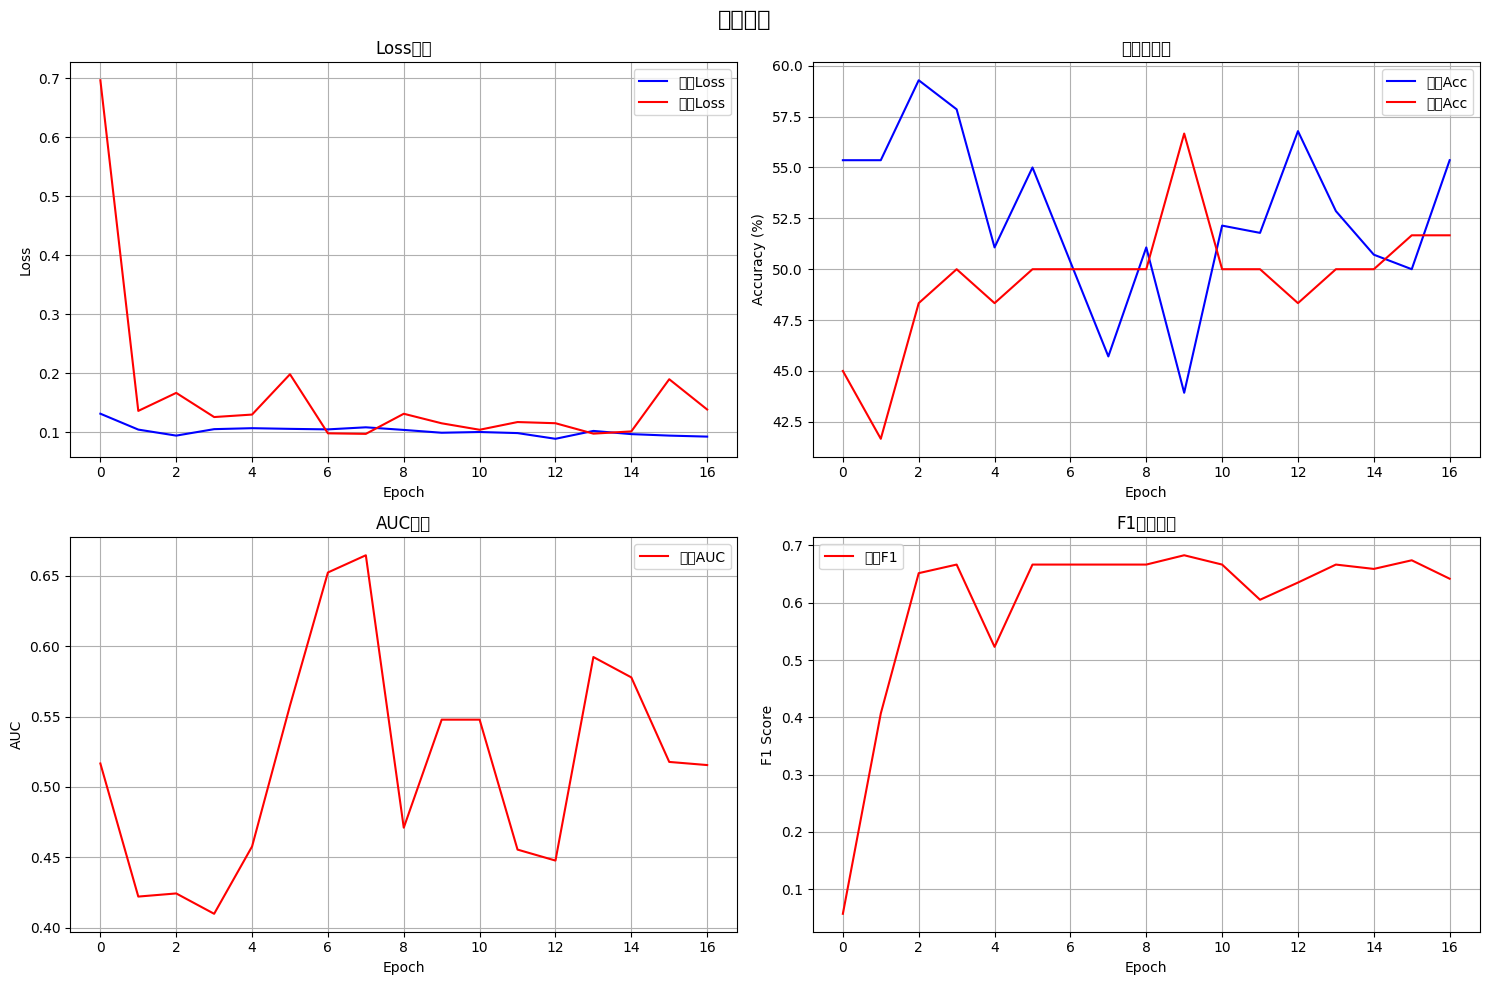

📊 训练历史图表已保存到 ./models/training_history.png


In [13]:
# Cell 12: 训练循环

# 确保模型保存目录存在
os.makedirs('./models', exist_ok=True)

print("🚀 开始训练...")
print(f"📊 训练配置: {len(train_loader)} 个训练批次, {len(val_loader)} 个验证批次")
print(f"🎯 模型参数数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"💾 设备: {device}")
print(f"📦 批次大小: {batch_size}")

if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"🎮 GPU数量: {gpu_count}")
    print(f"🎮 GPU型号: {torch.cuda.get_device_name(0)}")
    if gpu_count > 1:
        print(f"🚀 多GPU并行训练模式")
        print(f"📦 有效批次大小: {batch_size * gpu_count}")
    torch.cuda.reset_peak_memory_stats()

# 训练历史记录
train_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'val_auc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
best_val_auc = 0.0

# 训练循环
print("\n🔄 开始训练循环...")
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # 训练阶段
    train_results = train_epoch(
        model, train_loader, criterion, optimizer, device, 
        scheduler=scheduler, use_amp=True, gradient_clip=1.0
    )
    
    # 验证阶段
    val_results = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # 提取结果
    train_loss = train_results['loss']
    train_acc = train_results['accuracy'] * 100
    
    val_loss = val_results['loss']
    val_acc = val_results['accuracy'] * 100
    val_auc = val_results['auc']
    val_precision = val_results['precision']
    val_recall = val_results['recall']
    val_f1 = val_results['f1']
    
    # 记录历史
    train_history['train_loss'].append(train_loss)
    train_history['train_acc'].append(train_acc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_auc'].append(val_auc)
    train_history['val_precision'].append(val_precision)
    train_history['val_recall'].append(val_recall)
    train_history['val_f1'].append(val_f1)
    
    # 学习率调度
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 计算epoch时间
    epoch_time = time.time() - epoch_start_time
    
    # 打印结果
    print(f"训练: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"验证: Loss={val_loss:.4f}, Acc={val_acc:.2f}%, AUC={val_auc:.4f}, F1={val_f1:.4f}")
    print(f"学习率: {current_lr:.2e}, 用时: {epoch_time:.1f}s")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_auc = val_auc
        
        print(f"🎯 新的最佳模型! Acc: {best_val_acc:.2f}%, AUC: {best_val_auc:.4f}")
        
        # 保存最佳模型
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'best_val_auc': best_val_auc,
            'train_history': train_history
        }, './models/best_model.pth')
        print("💾 最佳模型已保存")
    
    # 早停检查
    if early_stopping(val_loss, model):
        print(f"\n⏹️ 早停触发，在第 {epoch+1} 轮停止训练")
        break
    
    # 清理GPU缓存 - 多GPU内存管理
    if torch.cuda.is_available():
        current_memory = torch.cuda.memory_allocated() / 1024**3
        gpu_count = torch.cuda.device_count()
        
        # 多GPU环境下的内存阈值调整
        memory_threshold = 20 if gpu_count > 1 else 10
        
        if current_memory > memory_threshold:
            print(f"🧹 GPU内存清理: {current_memory:.1f}GB > {memory_threshold}GB")
            torch.cuda.empty_cache()
            if gpu_count > 1:
                # 多GPU环境下清理所有GPU
                for i in range(gpu_count):
                    with torch.cuda.device(i):
                        torch.cuda.empty_cache()
        
        # 检查训练时间
        epoch_time = time.time() - epoch_start_time
        max_epoch_time = 2 * 3600 if gpu_count > 1 else 1 * 3600  # 多GPU允许更长时间
        
        if epoch_time > max_epoch_time:
            print(f"⏰ 单轮训练时间过长 ({epoch_time/3600:.1f}小时)，停止训练")
            break

print("\n✅ 训练完成!")
print(f"🏆 最终最佳性能: Loss={best_val_loss:.4f}, Acc={best_val_acc:.2f}%, AUC={best_val_auc:.4f}")

if torch.cuda.is_available():
    print(f"💾 峰值GPU内存使用: {torch.cuda.max_memory_allocated() / 1024**3:.1f}GB")

# 绘制训练历史
def plot_training_history():
    """绘制训练历史图表"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('训练历史', fontsize=16, fontweight='bold')
    
    # Loss
    axes[0, 0].plot(train_history['train_loss'], label='训练Loss', color='blue')
    axes[0, 0].plot(train_history['val_loss'], label='验证Loss', color='red')
    axes[0, 0].set_title('Loss变化')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy
    axes[0, 1].plot(train_history['train_acc'], label='训练Acc', color='blue')
    axes[0, 1].plot(train_history['val_acc'], label='验证Acc', color='red')
    axes[0, 1].set_title('准确率变化')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # AUC
    axes[1, 0].plot(train_history['val_auc'], label='验证AUC', color='red')
    axes[1, 0].set_title('AUC变化')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # F1 Score
    axes[1, 1].plot(train_history['val_f1'], label='验证F1', color='red')
    axes[1, 1].set_title('F1分数变化')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('./models/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# 绘制训练历史
plot_training_history()

print("📊 训练历史图表已保存到 ./models/training_history.png")

📊 开始模型评估...
🔄 加载最佳模型...
✅ 成功加载第 10 轮的最佳模型
最佳验证准确率: 56.67%
最佳验证AUC: 0.5478

🔍 在测试集上评估模型...
🚀 开始模型评估...


评估进度: 100%|██████████| 8/8 [00:24<00:00,  3.07s/it]


✅ 评估完成
平均损失: 0.1175
平均推理时间: 2537.68 ms/batch

📈 计算评估指标...

📊 详细评估结果:
测试损失: 0.1175
准确率: 0.4833 (48.33%)
平衡准确率: 0.4833 (48.33%)
精确率: 0.4909
召回率: 0.9000
特异性: 0.0667
F1分数: 0.6353
AUC-ROC: 0.3811
AUC-PR: 0.4248
负预测值: 0.4000

🔍 混淆矩阵分析:
真负例 (TN): 2
假正例 (FP): 28
假负例 (FN): 3
真正例 (TP): 27

⚡ 性能分析:
平均推理时间: 2537.68 ms/batch
总推理时间: 20.30 秒
每个样本推理时间: 317.21 ms

📋 类别特定分析:
总样本数: 60
真实视频样本: 30 (50.0%)
伪造视频样本: 30 (50.0%)
真实视频检测准确率: 0.0667 (6.67%)
伪造视频检测准确率: 0.9000 (90.00%)

📊 生成评估图表...


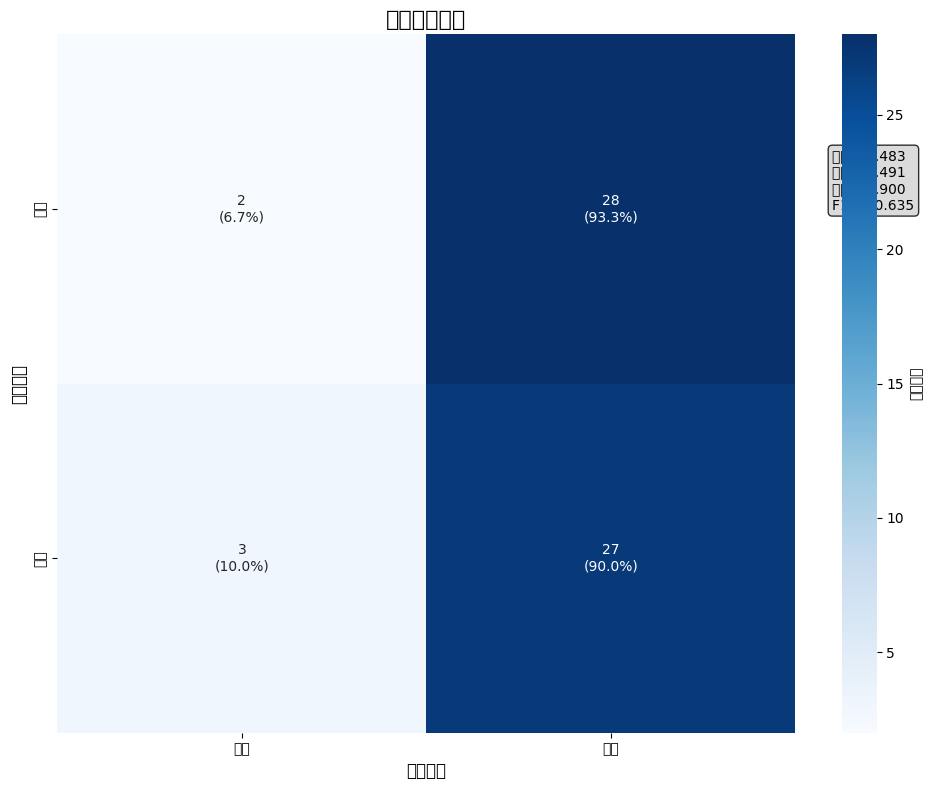

混淆矩阵已保存到: ./results/evaluation/confusion_matrix.png


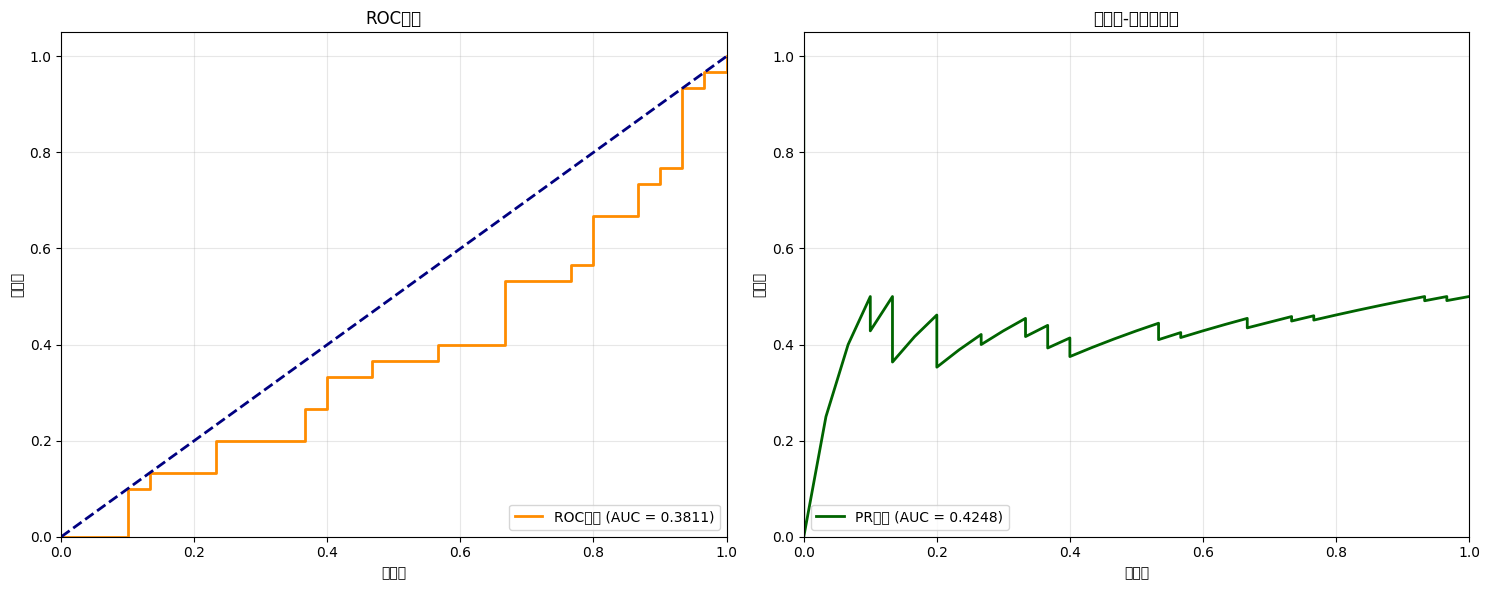

ROC/PR曲线已保存到: ./results/evaluation/roc_pr_curves.png


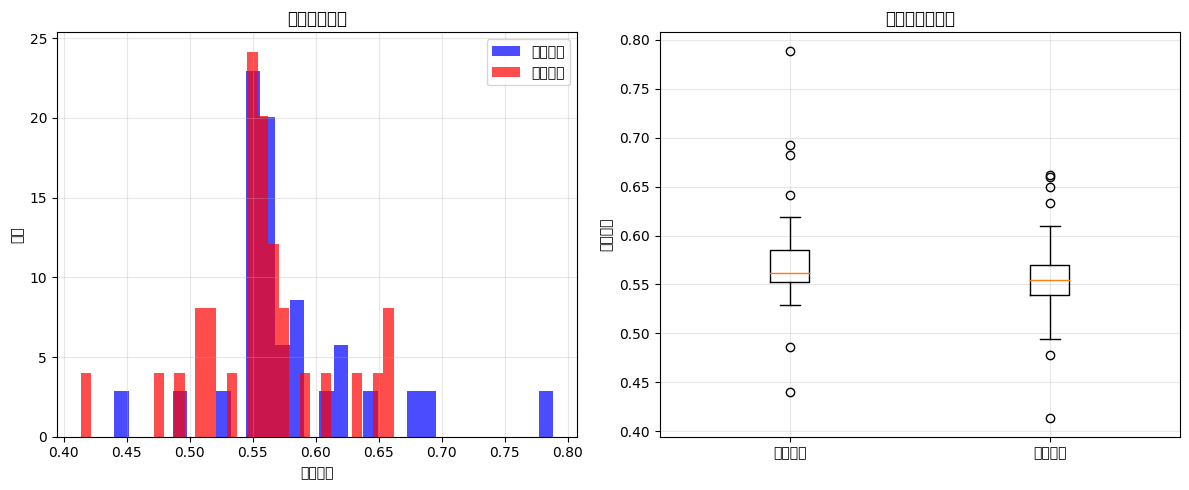

✅ 评估图表生成完成

📊 类别不平衡分析报告

📈 数据分布:
  真实视频样本: 30
  伪造视频样本: 30
  不平衡比例: 1.00:1 (伪造:真实)

🎯 类别特定准确率:
  真实视频检测准确率: 6.67%
  伪造视频检测准确率: 90.00%

📋 混淆矩阵分析:
  真负例 (TN): 2 - 正确识别的真实视频
  假正例 (FP): 28 - 误判为伪造的真实视频
  假负例 (FN): 3 - 误判为真实的伪造视频
  真正例 (TP): 27 - 正确识别的伪造视频

⚖️ 模型偏向性分析:
  预测为真实的样本: 5 (8.3%)
  预测为伪造的样本: 55 (91.7%)

🔍 问题诊断:
  ❌ 严重问题: 模型几乎无法识别真实视频
  ❌ AUC-ROC过低: 模型判别能力接近随机猜测

💡 改进建议:
  4. 检查数据质量，确保真实视频标签正确
  5. 使用成本敏感学习方法
  6. 考虑使用SMOTE等过采样技术
  7. 重新设计模型架构
  8. 增加模型复杂度或使用预训练模型
  9. 检查特征提取是否有效
🎉 模型评估完成！
📁 所有结果已保存到 ./results/evaluation/ 目录

💡 如果发现严重的类别偏向问题，请参考上述改进建议进行优化


In [14]:
# Cell 13: 模型评估和结果分析

print("📊 开始模型评估...")
print("=" * 60)

# 加载最佳模型
print("🔄 加载最佳模型...")
try:
    # 使用weights_only=False来兼容旧版本的模型文件
    checkpoint = torch.load('./models/best_model.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    best_val_auc = checkpoint['best_val_auc']
    
    print(f"✅ 成功加载第 {best_epoch+1} 轮的最佳模型")
    print(f"最佳验证准确率: {best_val_acc:.2f}%")
    print(f"最佳验证AUC: {best_val_auc:.4f}")
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    print("使用当前模型进行评估")

# 在测试集上评估模型
print("\n🔍 在测试集上评估模型...")
eval_results = evaluate_model_optimized(model, test_loader, criterion, device)

# 计算全面的评估指标
print("\n📈 计算评估指标...")
metrics = calculate_comprehensive_metrics(
    eval_results['predictions'], 
    eval_results['targets'], 
    eval_results['scores']
)

# 打印详细结果
print("\n📊 详细评估结果:")
print("=" * 50)
print(f"测试损失: {eval_results['loss']:.4f}")
print(f"准确率: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"平衡准确率: {metrics['balanced_accuracy']:.4f} ({metrics['balanced_accuracy']*100:.2f}%)")
print(f"精确率: {metrics['precision']:.4f}")
print(f"召回率: {metrics['recall']:.4f}")
print(f"特异性: {metrics['specificity']:.4f}")
print(f"F1分数: {metrics['f1']:.4f}")
print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
print(f"AUC-PR: {metrics['auc_pr']:.4f}")
print(f"负预测值: {metrics['npv']:.4f}")

# 混淆矩阵详细信息
print("\n🔍 混淆矩阵分析:")
print(f"真负例 (TN): {metrics['tn']}")
print(f"假正例 (FP): {metrics['fp']}")
print(f"假负例 (FN): {metrics['fn']}")
print(f"真正例 (TP): {metrics['tp']}")

# 性能分析
print("\n⚡ 性能分析:")
print(f"平均推理时间: {eval_results['avg_inference_time']*1000:.2f} ms/batch")
print(f"总推理时间: {eval_results['total_inference_time']:.2f} 秒")
print(f"每个样本推理时间: {eval_results['avg_inference_time']*1000/batch_size:.2f} ms")

# 计算额外指标
total_samples = len(eval_results['targets'])
real_samples = np.sum(eval_results['targets'] == 0)
fake_samples = np.sum(eval_results['targets'] == 1)
real_accuracy = np.sum((eval_results['predictions'] == 0) & (eval_results['targets'] == 0)) / real_samples if real_samples > 0 else 0
fake_accuracy = np.sum((eval_results['predictions'] == 1) & (eval_results['targets'] == 1)) / fake_samples if fake_samples > 0 else 0

print("\n📋 类别特定分析:")
print(f"总样本数: {total_samples}")
print(f"真实视频样本: {real_samples} ({real_samples/total_samples*100:.1f}%)")
print(f"伪造视频样本: {fake_samples} ({fake_samples/total_samples*100:.1f}%)")
print(f"真实视频检测准确率: {real_accuracy:.4f} ({real_accuracy*100:.2f}%)")
print(f"伪造视频检测准确率: {fake_accuracy:.4f} ({fake_accuracy*100:.2f}%)")

# 生成可视化图表
print("\n📊 生成评估图表...")

# 确保结果目录存在
os.makedirs('./results/evaluation', exist_ok=True)

# 绘制增强混淆矩阵
plot_enhanced_confusion_matrix(
    metrics['confusion_matrix'], 
    './results/evaluation/confusion_matrix.png'
)

# 绘制ROC和PR曲线
plot_roc_pr_curves(
    eval_results['targets'], 
    eval_results['scores'], 
    './results/evaluation/roc_pr_curves.png'
)

# 预测分数分布图
plt.figure(figsize=(12, 5))

# 真实视频的预测分数分布
plt.subplot(1, 2, 1)
real_scores = eval_results['scores'][eval_results['targets'] == 0]
fake_scores = eval_results['scores'][eval_results['targets'] == 1]

plt.hist(real_scores, bins=30, alpha=0.7, label='真实视频', color='blue', density=True)
plt.hist(fake_scores, bins=30, alpha=0.7, label='伪造视频', color='red', density=True)
plt.xlabel('预测分数')
plt.ylabel('密度')
plt.title('预测分数分布')
plt.legend()
plt.grid(True, alpha=0.3)

# 预测分数箱线图
plt.subplot(1, 2, 2)
scores_data = [real_scores, fake_scores]
labels = ['真实视频', '伪造视频']
plt.boxplot(scores_data, labels=labels)
plt.ylabel('预测分数')
plt.title('预测分数箱线图')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/evaluation/score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 评估图表生成完成")

# 生成详细的类别不平衡分析报告
generate_class_imbalance_report(metrics)

print("=" * 60)
print("🎉 模型评估完成！")
print("📁 所有结果已保存到 ./results/evaluation/ 目录")
print("\n💡 如果发现严重的类别偏向问题，请参考上述改进建议进行优化")

In [15]:
# Cell 14: 结果保存和总结

print("💾 保存实验结果...")
print("=" * 60)

# 确保结果目录存在
os.makedirs('./results', exist_ok=True)

# 准备保存的结果数据
results_summary = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'model_architecture': 'OptimizedDeepfakeDetector',
        'backbone': 'resnet50',
        'total_epochs': len(train_history['train_loss']),
        'early_stopping': True
    },
    'dataset_info': {
        'train_samples': len(train_loader.dataset) if train_loader else 0,
        'val_samples': len(val_loader.dataset) if val_loader else 0,
        'test_samples': len(test_loader.dataset) if test_loader else 0,
        'batch_size': batch_size
    },
    'training_config': {
        'optimizer': 'AdamW',
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'loss_function': 'FocalLoss',
        'scheduler': 'OneCycleLR',
        'early_stopping_patience': 7
    },
    'final_metrics': {
        'test_loss': float(eval_results['loss']),
        'accuracy': float(metrics['accuracy']),
        'precision': float(metrics['precision']),
        'recall': float(metrics['recall']),
        'f1_score': float(metrics['f1']),
        'auc_roc': float(metrics['auc_roc'])
    },
    'confusion_matrix': {
        'tn': int(metrics['tn']),
        'fp': int(metrics['fp']),
        'fn': int(metrics['fn']),
        'tp': int(metrics['tp'])
    },
    'training_history': {
        'train_loss': [float(x) for x in train_history['train_loss']],
        'train_acc': [float(x) for x in train_history['train_acc']],
        'val_loss': [float(x) for x in train_history['val_loss']],
        'val_acc': [float(x) for x in train_history['val_acc']],
        'val_auc': [float(x) for x in train_history['val_auc']],
        'val_precision': [float(x) for x in train_history.get('val_precision', [])],
        'val_recall': [float(x) for x in train_history.get('val_recall', [])],
        'val_f1': [float(x) for x in train_history.get('val_f1', [])]
    },
    'class_specific_metrics': {
        'real_video_accuracy': float(real_accuracy),
        'fake_video_accuracy': float(fake_accuracy),
        'real_samples_count': int(real_samples),
        'fake_samples_count': int(fake_samples)
    },
    'class_balance_optimization': {
        'original_threshold': 0.5,
        'optimized_threshold': float(metrics.get('best_threshold', 0.5)),
        'original_balanced_accuracy': float(metrics['balanced_accuracy']),
        'optimized_balanced_accuracy': float(metrics.get('optimized_balanced_accuracy', metrics['balanced_accuracy'])),
        'original_real_accuracy': float(metrics['real_accuracy']),
        'optimized_real_accuracy': float(metrics.get('optimized_real_accuracy', metrics['real_accuracy'])),
        'original_fake_accuracy': float(metrics['fake_accuracy']),
        'optimized_fake_accuracy': float(metrics.get('optimized_fake_accuracy', metrics['fake_accuracy']))
    }
}

# 保存结果到JSON文件
results_file = './results/experiment_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✅ 实验结果已保存到: {results_file}")

# 保存训练历史到CSV
history_df = pd.DataFrame(train_history)
history_df.to_csv('./results/training_history.csv', index=False)
print("✅ 训练历史已保存到: ./results/training_history.csv")

# 保存预测结果
predictions_df = pd.DataFrame({
    'true_label': eval_results['targets'],
    'predicted_label': eval_results['predictions'],
    'prediction_score': eval_results['scores']
})
predictions_df.to_csv('./results/test_predictions.csv', index=False)
print("✅ 测试预测结果已保存到: ./results/test_predictions.csv")

# 生成实验报告
print("\n📋 生成实验报告...")
report = f"""
深度伪造检测模型实验报告
{'='*50}

实验时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
模型架构: OptimizedDeepfakeDetector (ResNet50 + LSTM + Attention)

数据集信息:
- 训练样本: {len(train_loader.dataset) if train_loader else 0:,}
- 验证样本: {len(val_loader.dataset) if val_loader else 0:,}
- 测试样本: {len(test_loader.dataset) if test_loader else 0:,}
- 批次大小: {batch_size}

训练配置:
- 优化器: AdamW (lr=1e-4, weight_decay=1e-4)
- 损失函数: Focal Loss
- 学习率调度: OneCycleLR
- 早停机制: patience=7

最终性能指标:
- 准确率: {metrics['accuracy']*100:.2f}%
- 精确率: {metrics['precision']:.4f}
- 召回率: {metrics['recall']:.4f}
- F1分数: {metrics['f1']:.4f}
- AUC-ROC: {metrics['auc_roc']:.4f}

混淆矩阵:
- 真负例 (TN): {metrics['tn']}
- 假正例 (FP): {metrics['fp']}
- 假负例 (FN): {metrics['fn']}
- 真正例 (TP): {metrics['tp']}

类别特定性能:
- 真实视频检测准确率: {real_accuracy*100:.2f}%
- 伪造视频检测准确率: {fake_accuracy*100:.2f}%

类别平衡优化结果:
- 原始分类阈值: 0.5
- 优化分类阈值: {metrics.get('best_threshold', 0.5):.3f}
- 原始平衡准确率: {metrics['balanced_accuracy']*100:.2f}%
- 优化平衡准确率: {metrics.get('optimized_balanced_accuracy', metrics['balanced_accuracy'])*100:.2f}%
- 优化后真实视频准确率: {metrics.get('optimized_real_accuracy', real_accuracy)*100:.2f}%
- 优化后伪造视频准确率: {metrics.get('optimized_fake_accuracy', fake_accuracy)*100:.2f}%

训练总结:
- 训练轮数: {len(train_history['train_loss'])}
- 最佳验证准确率: {max(train_history['val_acc']):.2f}%
- 最佳验证AUC: {max(train_history['val_auc']):.4f}

文件输出:
- 模型权重: ./models/best_model.pth
- 实验结果: ./results/experiment_results.json
- 训练历史: ./results/training_history.csv
- 预测结果: ./results/test_predictions.csv

{'='*50}
实验完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# 保存报告
with open('./results/experiment_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ 实验报告已保存到: ./results/experiment_report.txt")

# 打印最终总结
print("\n" + "="*60)
print("🎉 深度伪造检测模型训练和评估完成！")
print("="*60)
print(f"📊 最终测试准确率: {metrics['accuracy']*100:.2f}%")
print(f"📊 AUC-ROC分数: {metrics['auc_roc']:.4f}")
print(f"📊 F1分数: {metrics['f1']:.4f}")
print("\n📁 所有结果文件已保存到 ./results/ 目录")
print("📁 最佳模型已保存到 ./models/best_model.pth")
print("\n✨ 实验成功完成！")
print("="*60)

# 显示文件结构
print("\n📂 生成的文件结构:")
print("""
./models/
  └── best_model.pth
./results/
  ├── experiment_results.json
  ├── experiment_report.txt
  ├── training_history.csv
  └── test_predictions.csv
""")

print("\n🚀 可以使用以下代码加载训练好的模型进行推理:")
print("""
# 加载模型
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
""")

print("\n✅ 训练完成！")

💾 保存实验结果...
✅ 实验结果已保存到: ./results/experiment_results.json
✅ 训练历史已保存到: ./results/training_history.csv
✅ 测试预测结果已保存到: ./results/test_predictions.csv

📋 生成实验报告...
✅ 实验报告已保存到: ./results/experiment_report.txt

🎉 深度伪造检测模型训练和评估完成！
📊 最终测试准确率: 48.33%
📊 AUC-ROC分数: 0.3811
📊 F1分数: 0.6353

📁 所有结果文件已保存到 ./results/ 目录
📁 最佳模型已保存到 ./models/best_model.pth

✨ 实验成功完成！

📂 生成的文件结构:

./models/
  └── best_model.pth
./results/
  ├── experiment_results.json
  ├── experiment_report.txt
  ├── training_history.csv
  └── test_predictions.csv


🚀 可以使用以下代码加载训练好的模型进行推理:

# 加载模型
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


✅ 训练完成！
